In [1]:
import sys
import os
from pathlib import PurePath, Path

PROJECT_ROOT_PATH = PurePath(os.getcwd()).parents[0]
RESOURCES_PATH = Path(PROJECT_ROOT_PATH, "resources")
SRC_PATH = PROJECT_ROOT_PATH.joinpath('src')

# if SRC_PATH not in sys.path:
#     sys.path.insert(0, str(SRC_PATH))
    

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot, lag_plot


from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss


from scipy.stats import linregress
from scipy import signal

from dateutil.parser import parse 

plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 200})
plt.style.use('seaborn-v0_8')

# Time series

Let's first have a look a series of values over time.
A simple dataset for this is the 'anti-diabetic drug sales in Australia'.



In [3]:
a10_df = pd.read_csv(Path(RESOURCES_PATH, "a10.csv"), parse_dates=['date'])
a10_df.head()

date     value
0 1991-07-01  3.526591
1 1991-08-01  3.180891
2 1991-09-01  3.252221
3 1991-10-01  3.611003
4 1991-11-01  3.565869

In [4]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value'):
    plt.figure(figsize=(16,5))
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()


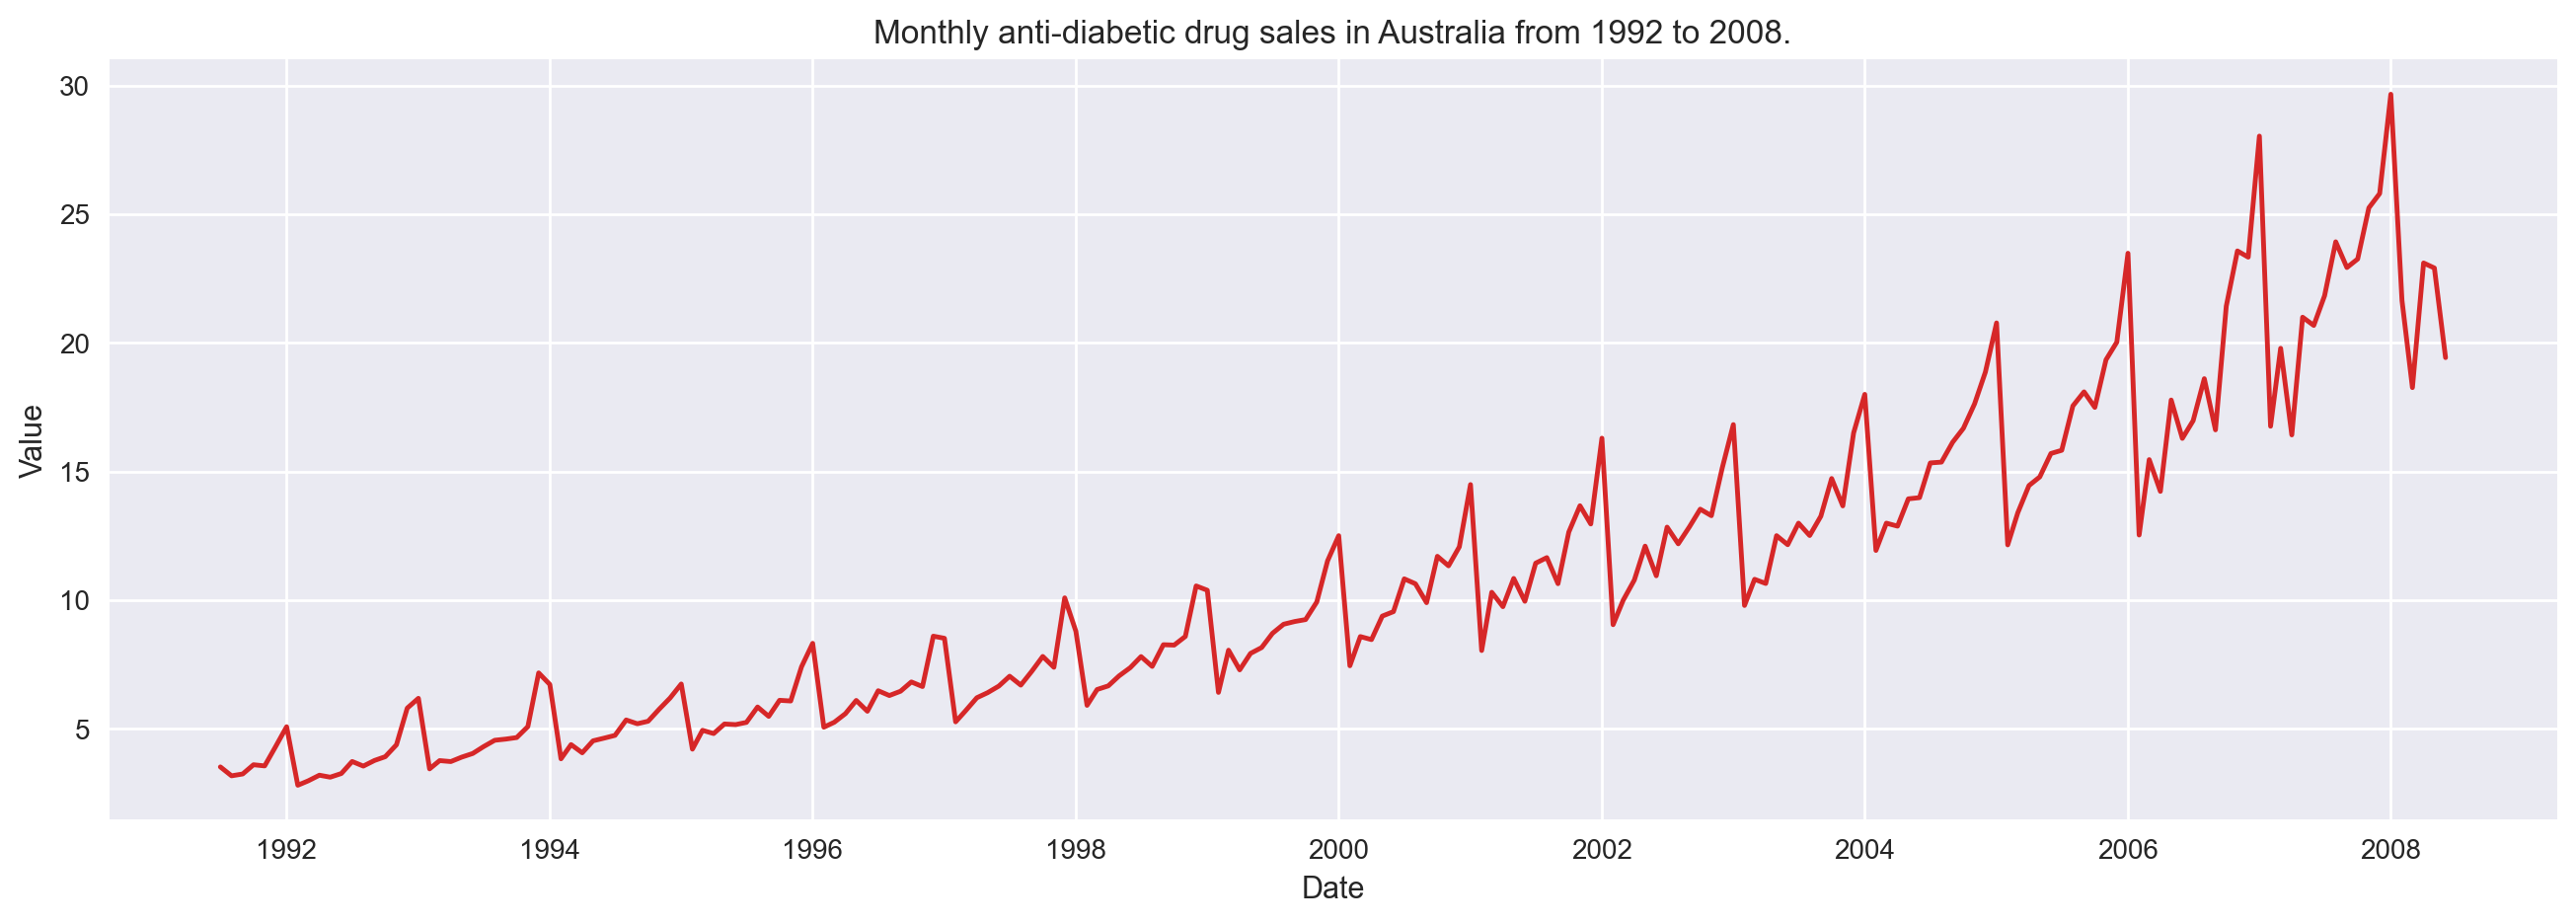

In [5]:
plot_df(a10_df, x=a10_df.date, y=a10_df.value, title='Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')    

In [6]:
def plot_mirrored(df, x, y, title="", xlabel='Date', ylabel='Value', y_scale=800):
    fig, ax = plt.subplots(1, 1, figsize=(16,5))
    plt.fill_between(x, y1=y, y2=-y, alpha=0.5, linewidth=2, color='seagreen')
    plt.ylim(-y_scale, y_scale)
    plt.title(title, fontsize=16)
    plt.hlines(y=0, xmin=np.min(df.date), xmax=np.max(df.date), linewidth=.5)
    plt.show()


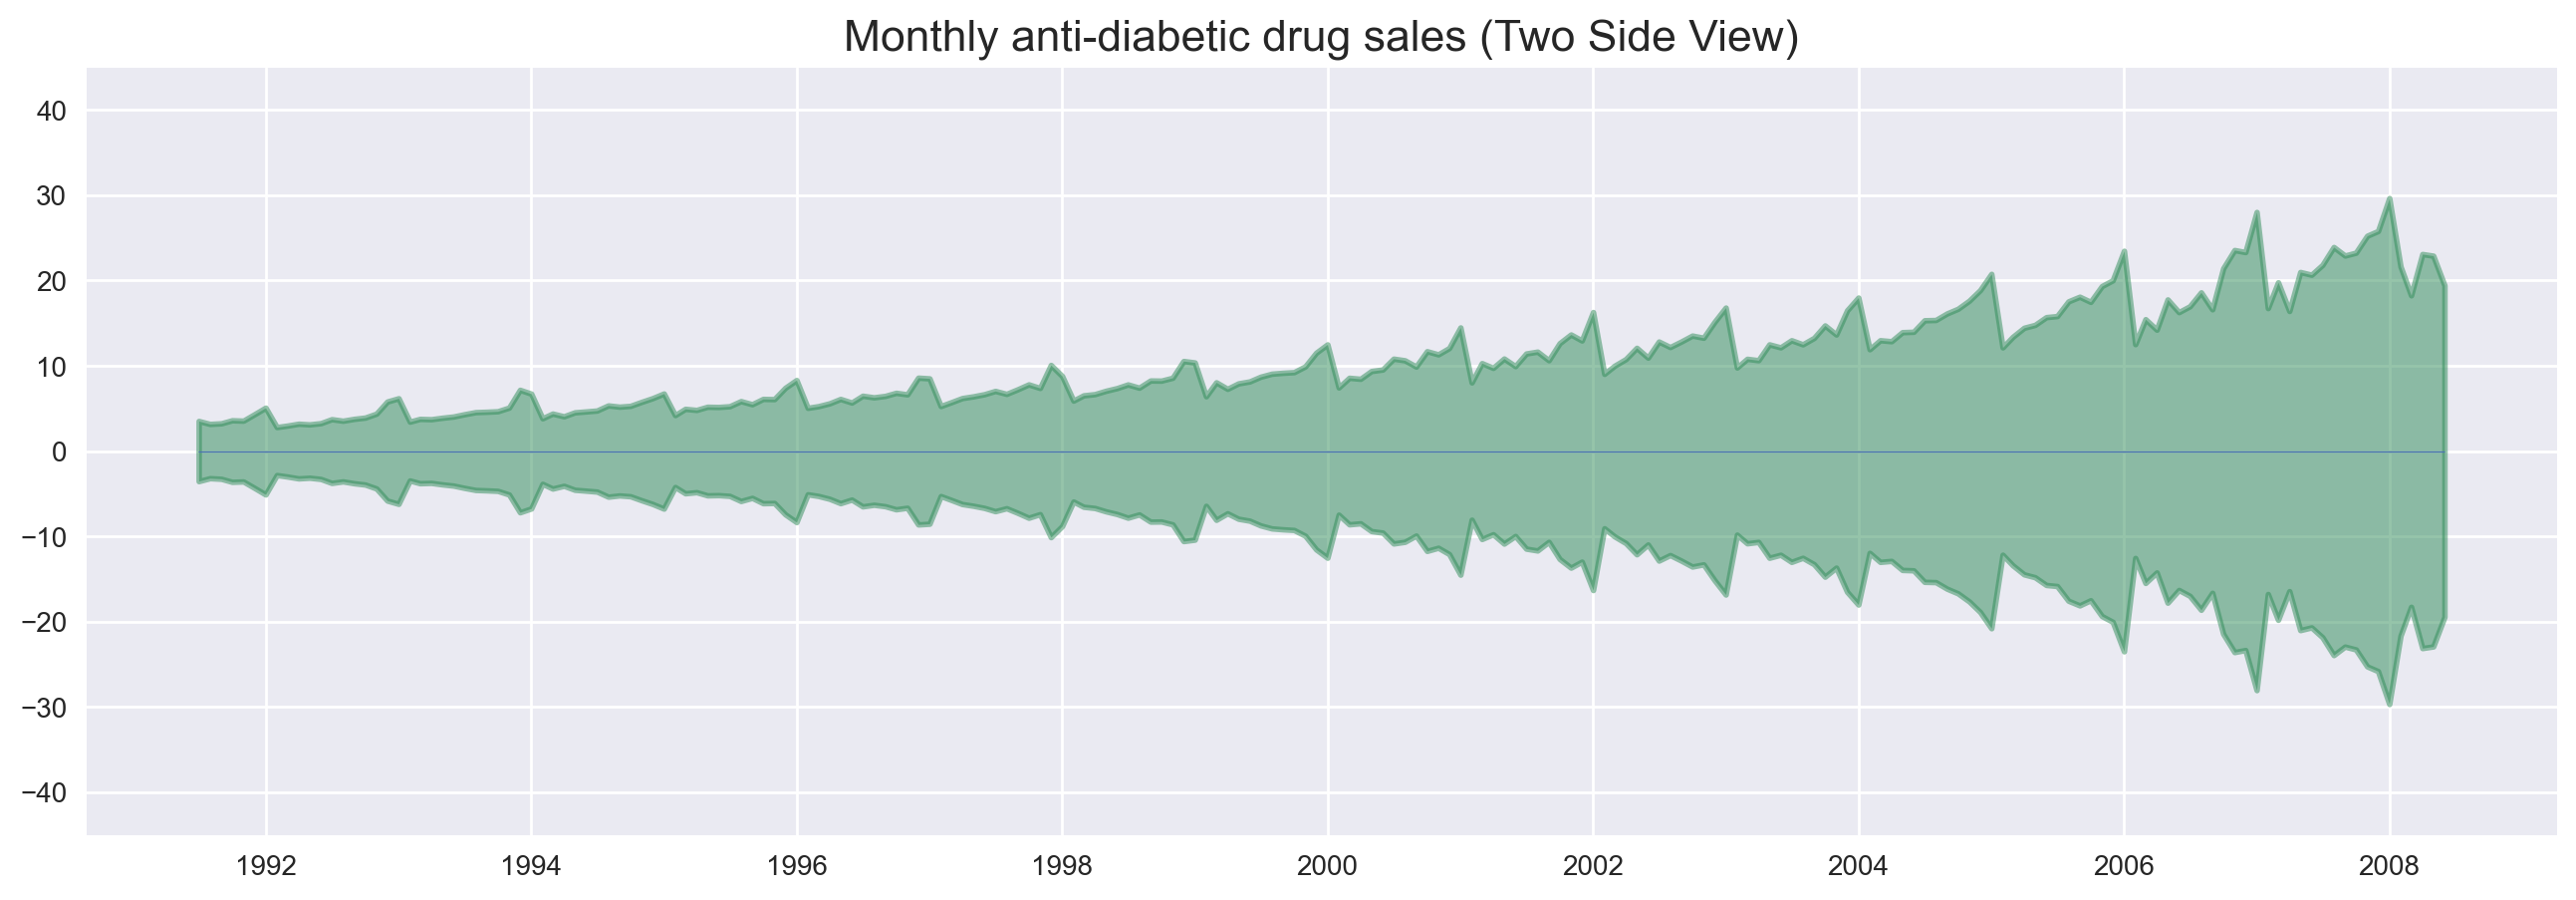

In [7]:
plot_mirrored(a10_df, 
              x=a10_df.date,
              y=a10_df.value, 
              y_scale=45,
              title='Monthly anti-diabetic drug sales (Two Side View)')  

This dataset is in a monthly frequency. Let's plot each year as a separate line to compare the monthly variation year by year.

In [8]:
copy_df = a10_df.copy()
copy_df["year"] = copy_df.date.dt.year
copy_df["month"] = copy_df.date.dt.strftime('%b')
copy_df


date      value  year month
0   1991-07-01   3.526591  1991   Jul
1   1991-08-01   3.180891  1991   Aug
2   1991-09-01   3.252221  1991   Sep
3   1991-10-01   3.611003  1991   Oct
4   1991-11-01   3.565869  1991   Nov
..         ...        ...   ...   ...
199 2008-02-01  21.654285  2008   Feb
200 2008-03-01  18.264945  2008   Mar
201 2008-04-01  23.107677  2008   Apr
202 2008-05-01  22.912510  2008   May
203 2008-06-01  19.431740  2008   Jun

[204 rows x 4 columns]

In [9]:
years_sequence = copy_df.year.unique()

In [10]:
def plot_yearly_lines(df, years, title, x_label, y_label):
    plt.figure(figsize=(16,12))
    color_map = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

    for i, year in enumerate(years):
        if i > 0:
            yearly_data = df.loc[df.year==year, :]
            plt.plot('month', 'value', data=yearly_data, color=color_map[i], label=year)
            plt.text(yearly_data.shape[0] - .9, yearly_data['value'].loc[-1:].values[0], year, fontsize=12, color=color_map[i])

    plt.gca().set(xlim=(-0.3, 11), ylim=(2, 30), ylabel=y_label, xlabel=x_label)
    plt.yticks(fontsize=12, alpha=.7)
    plt.title(title, fontsize=20)
    plt.show()
    
    


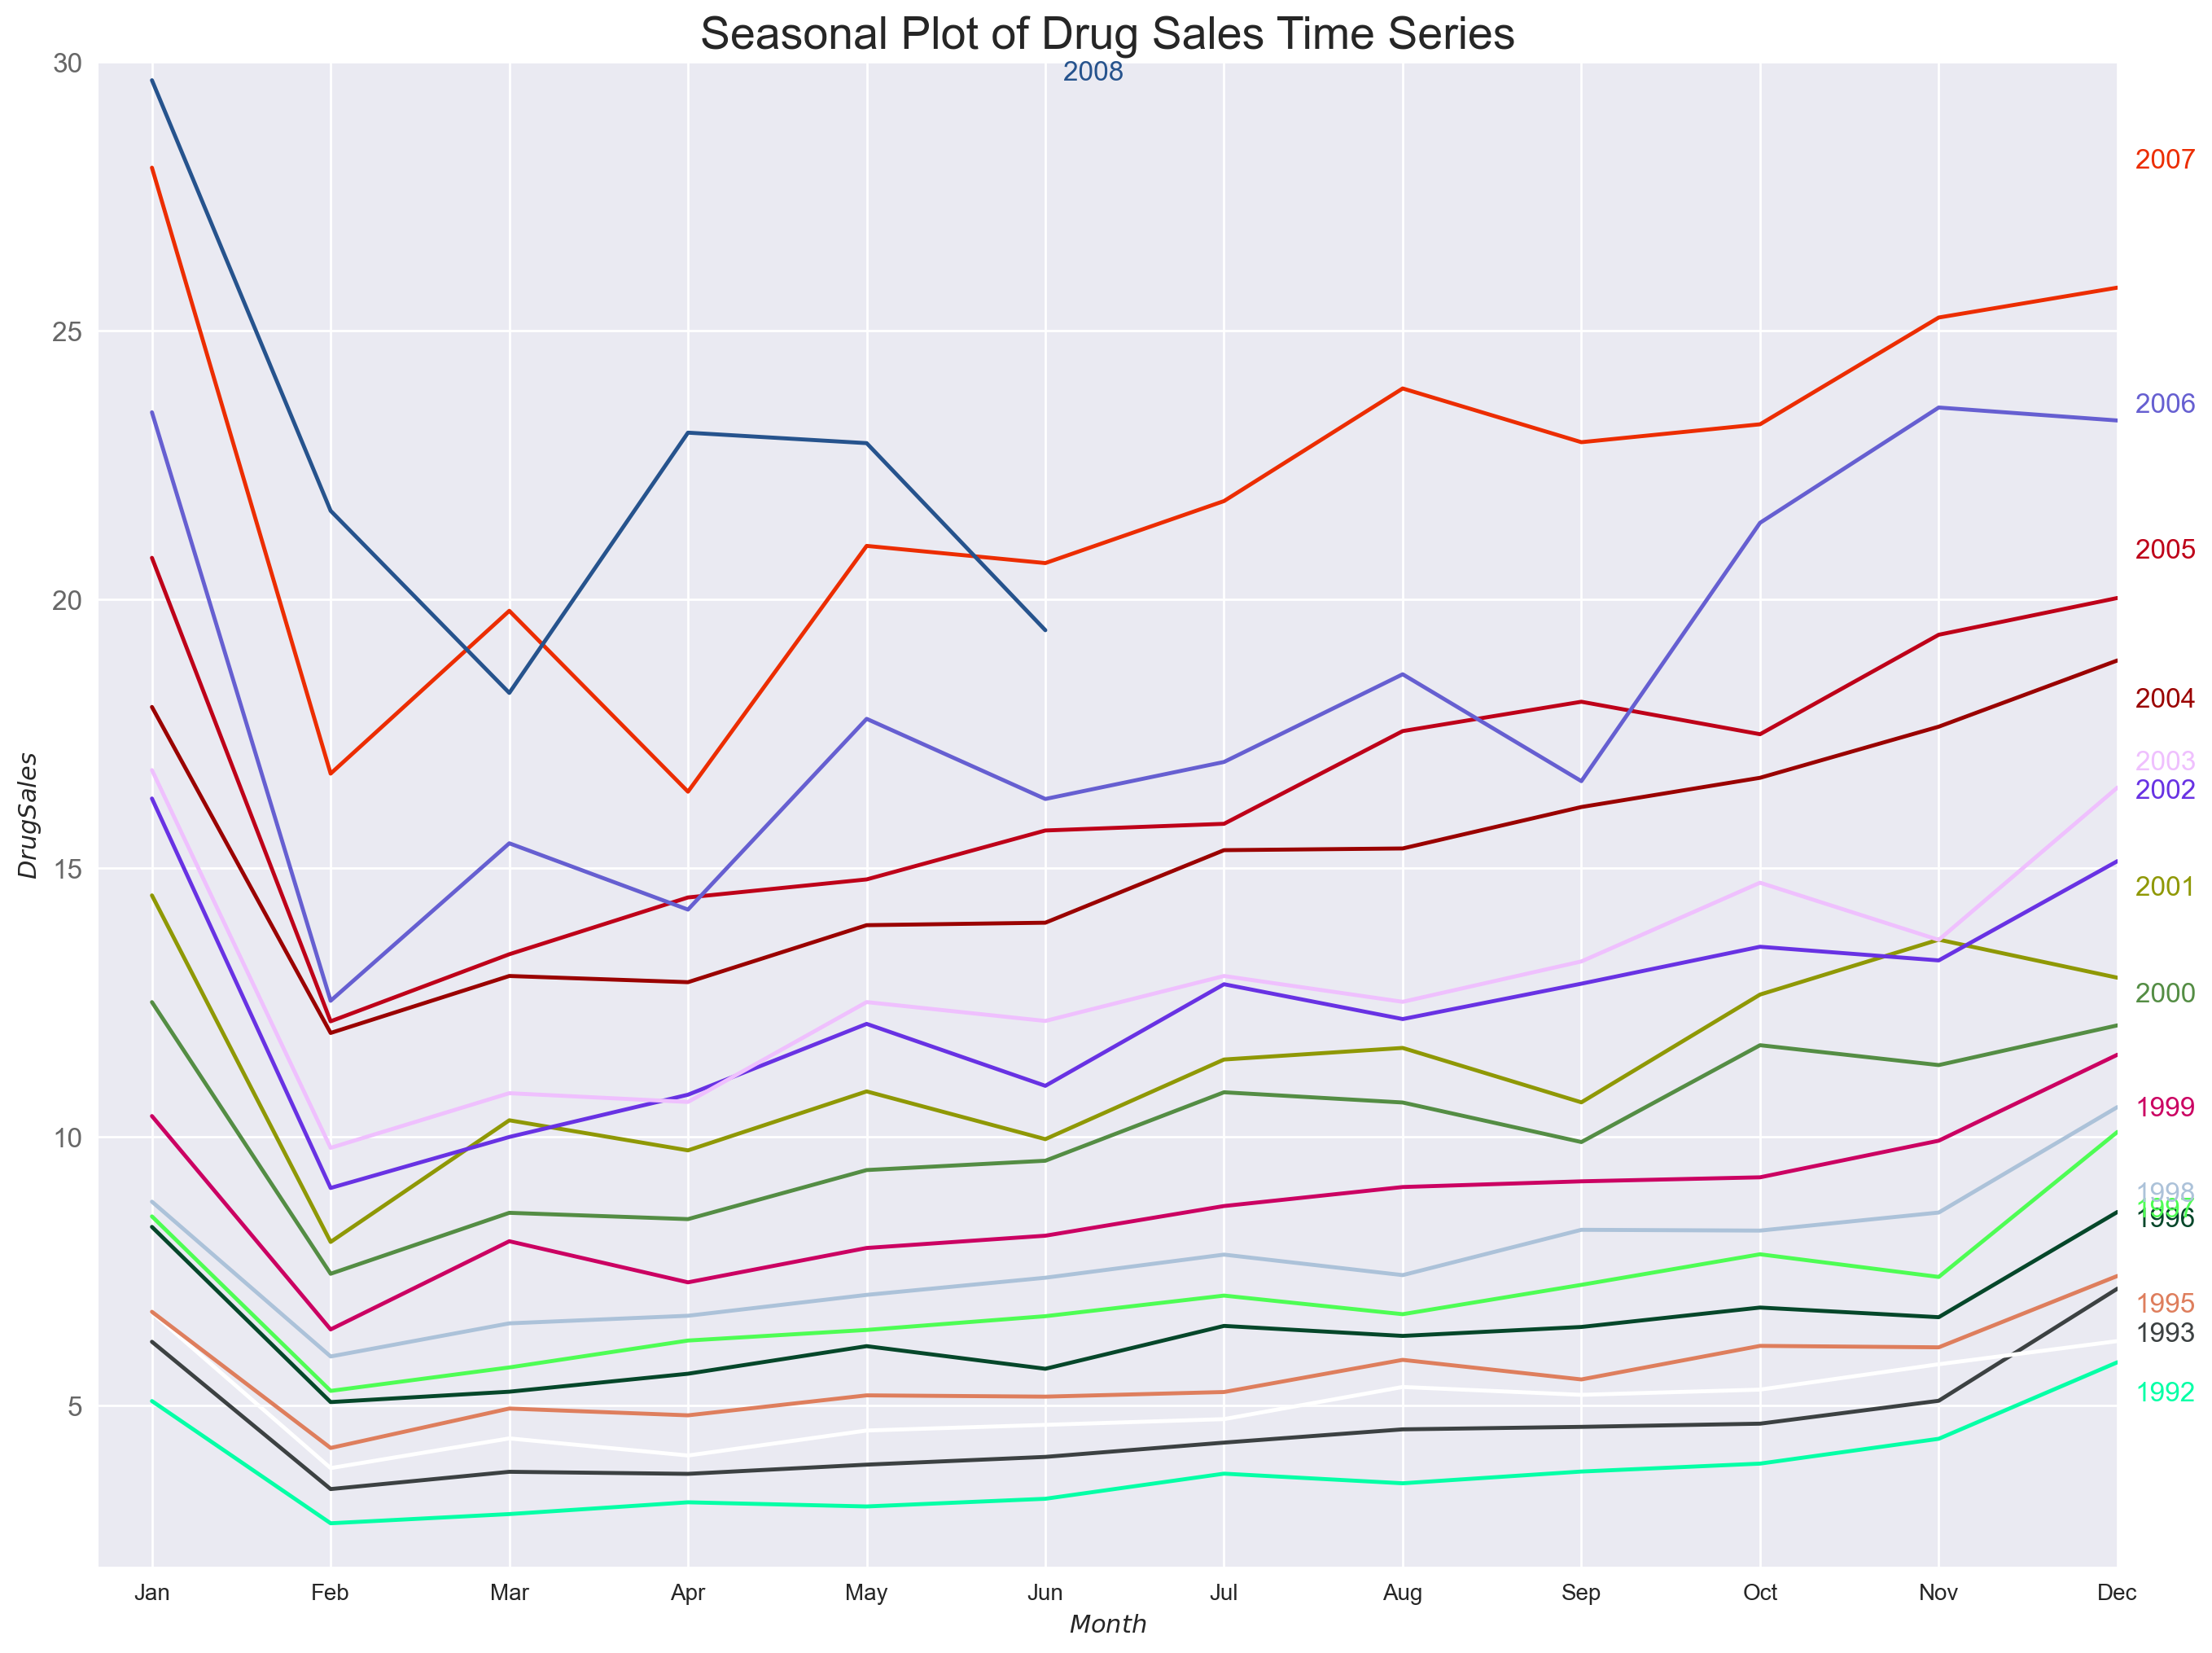

In [11]:
plot_yearly_lines(copy_df, years_sequence, title="Seasonal Plot of Drug Sales Time Series", y_label='$Drug Sales$', x_label='$Month$')

In [12]:
def plot_boxplot(df):
    fig, axes = plt.subplots(1, 2, figsize=(20,7))
    sns.boxplot(x='year', y='value', data=df, ax=axes[0])
    sns.boxplot(x='month', y='value', data=df)

    # Set Title
    axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
    axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
    plt.show()

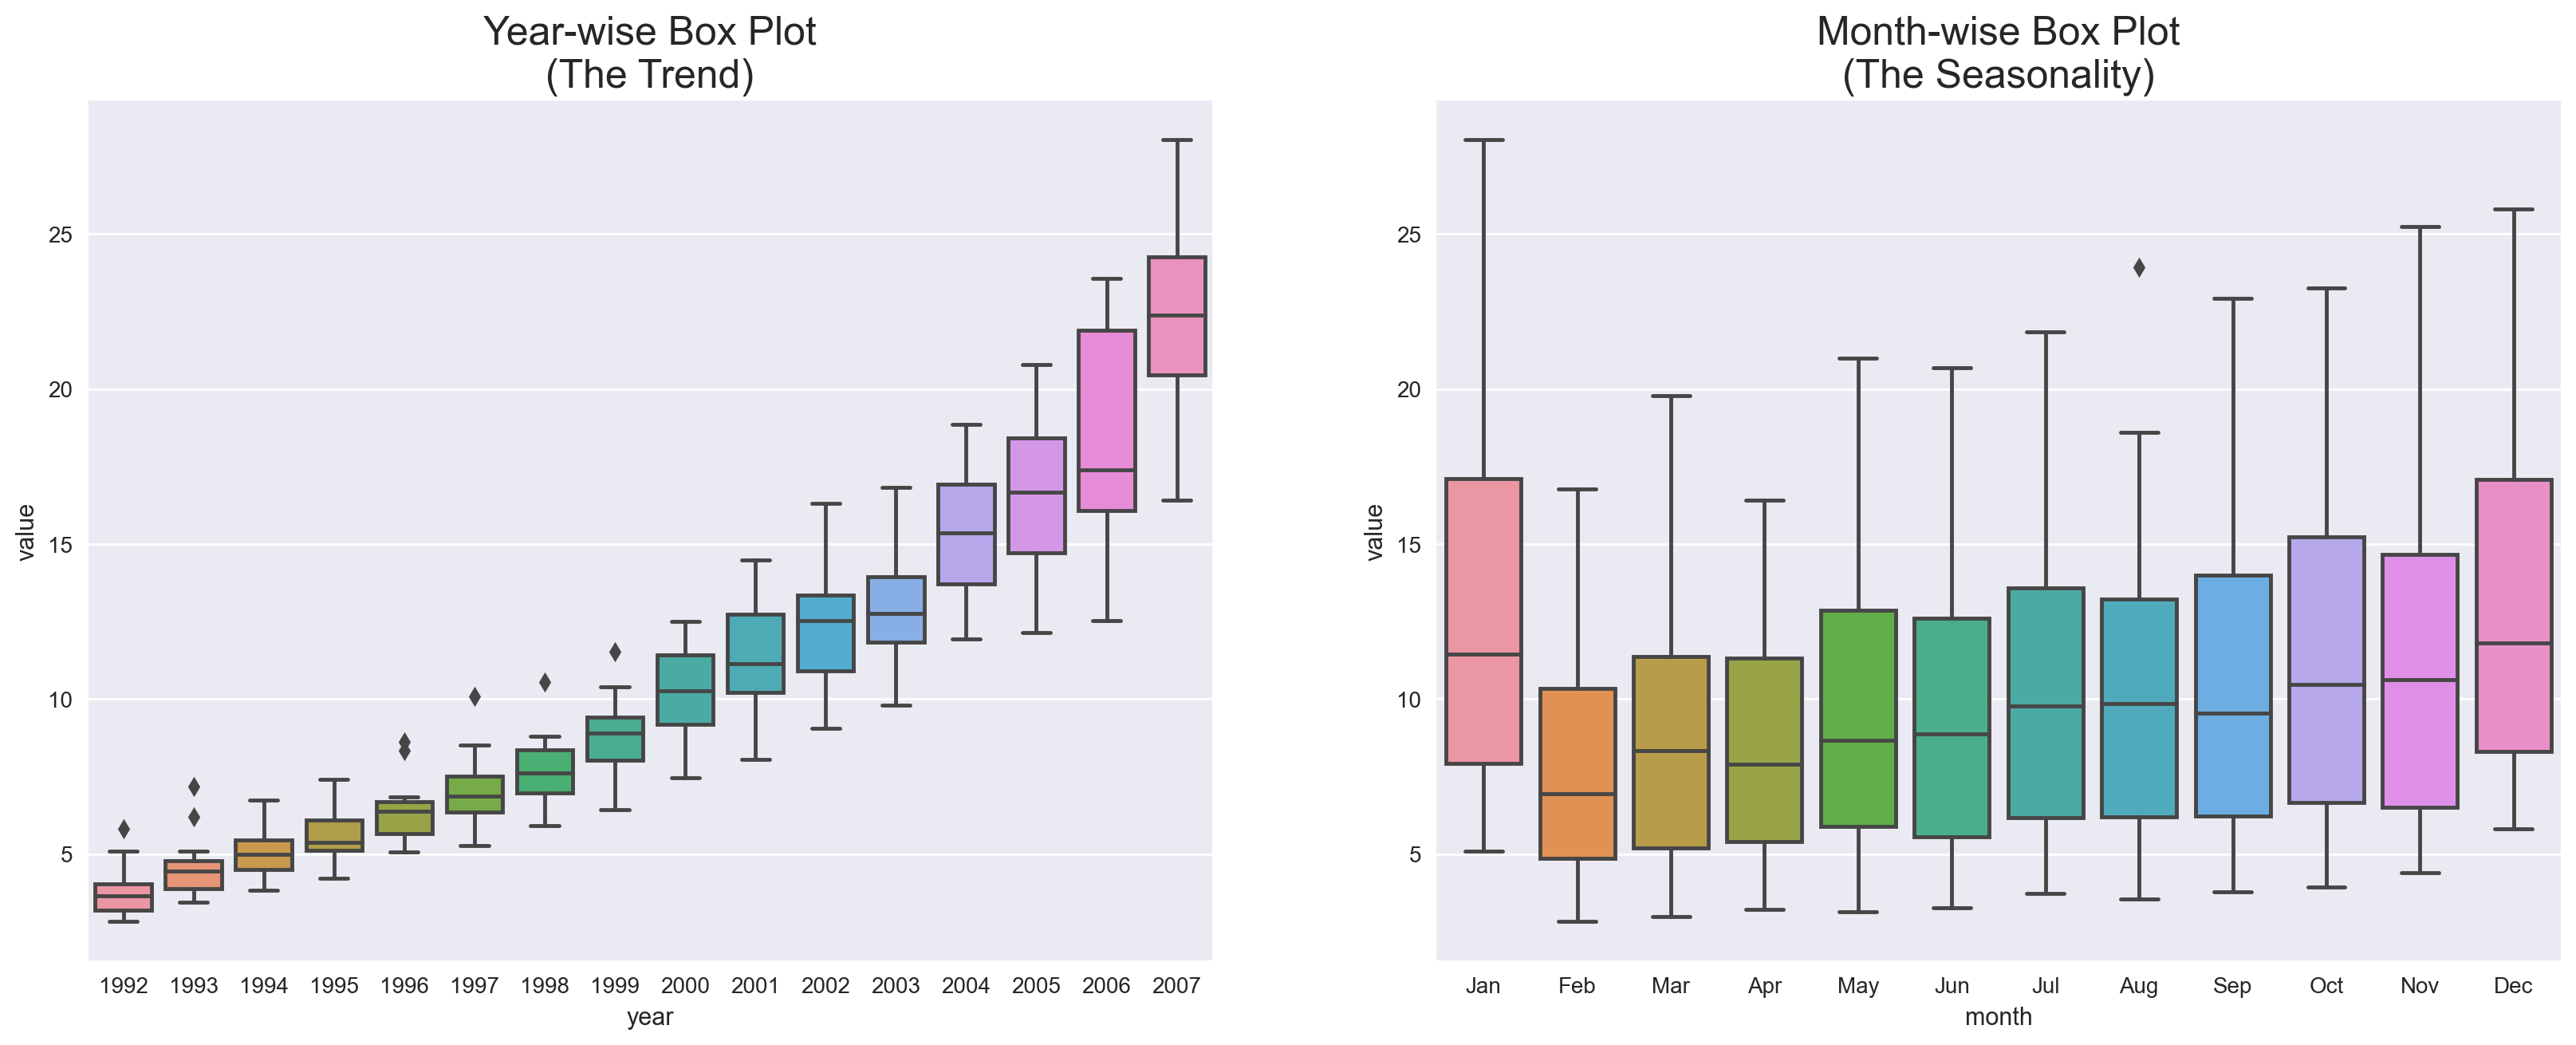

In [13]:
plot_boxplot(copy_df.loc[~copy_df.year.isin([1991, 2008]), :])

## Decomposing a time series

Any time series can be seen as a combination of:
- base level
- trend
- seasonality
- irreducible (residual) error


There is also a difference between `additive` and `multiplicative` time series.

**Additive**: `base` + `trend` + `seasonality` + $\epsilon$

**Multiplicative**: `base` * `trend` * `seasonality` * $\epsilon$


The `seasonal_decompose` in `statsmodels` implements the classical decomposition of a time series by considering the series as an additive or multiplicative combination of the base level, trend, seasonal index and the residual.




<AxesSubplot: title={'center': 'Trend and Seasonality'}, xlabel='date'>

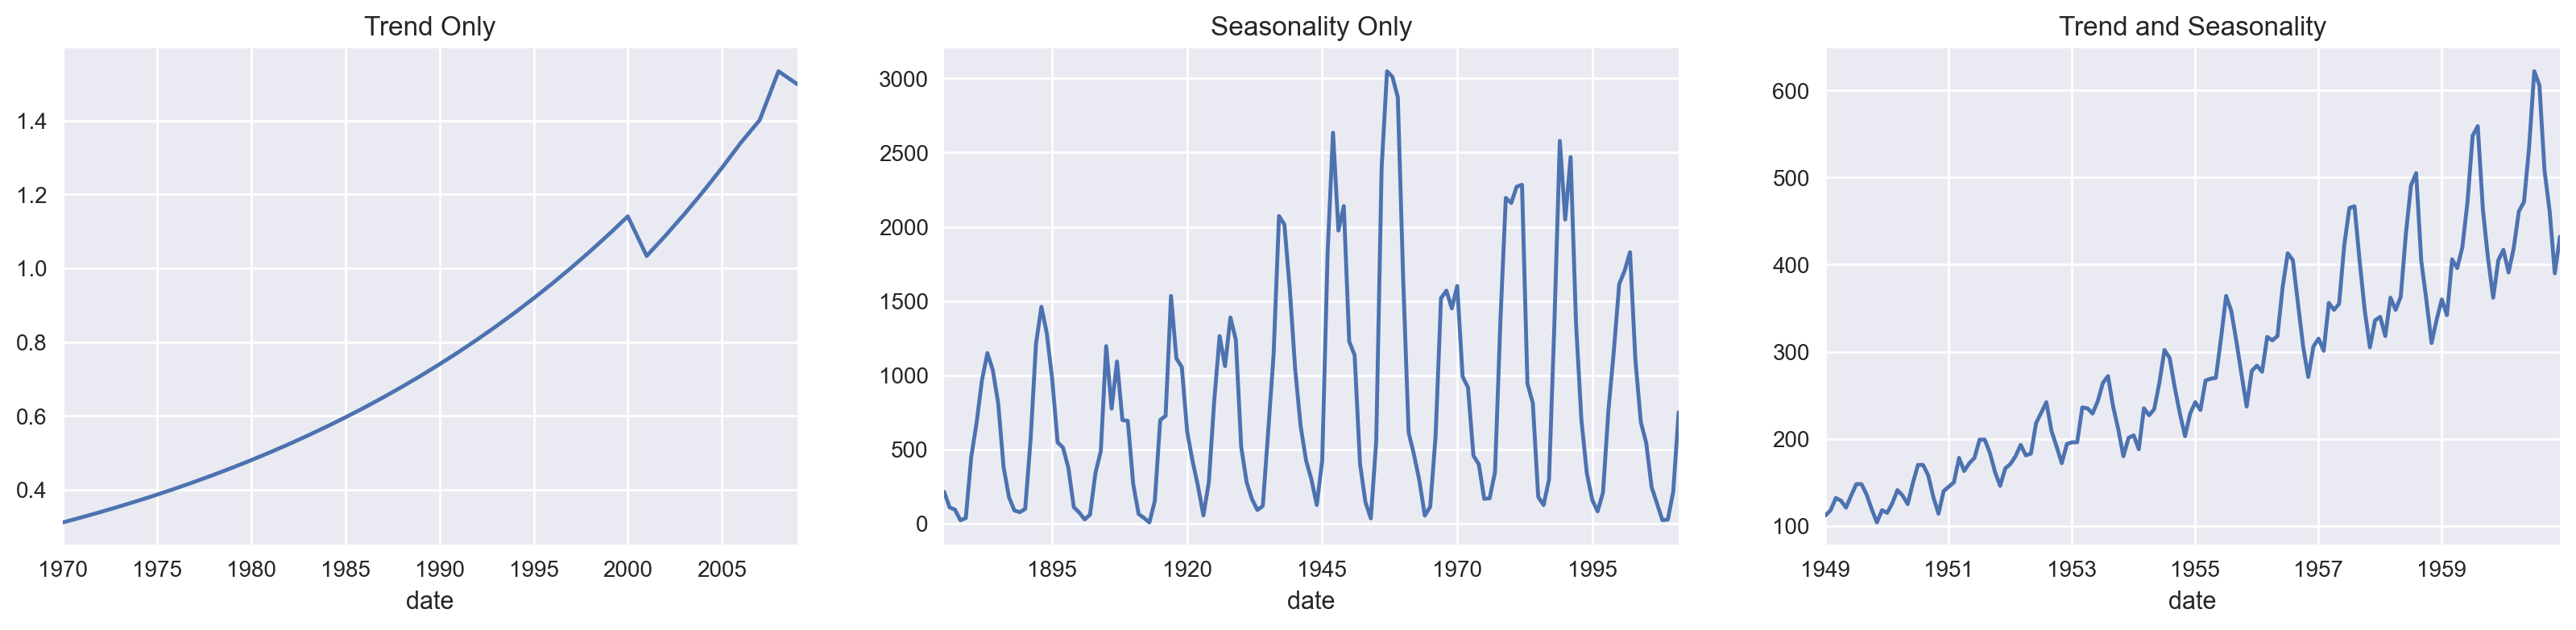

In [14]:
guinearice = pd.read_csv(Path(RESOURCES_PATH, "guinearice.csv"), parse_dates=['date'], index_col='date')
sunspotarea = pd.read_csv(Path(RESOURCES_PATH, "sunspotarea.csv"), parse_dates=['date'], index_col='date')
passangers = pd.read_csv(Path(RESOURCES_PATH, "AirPassengers.csv"), parse_dates=['date'], index_col='date')

fig, axes = plt.subplots(1,3, figsize=(20,4))
guinearice.plot(title='Trend Only', legend=False, ax=axes[0])
sunspotarea.plot(title='Seasonality Only', legend=False, ax=axes[1])
passangers.plot(title='Trend and Seasonality', legend=False, ax=axes[2])

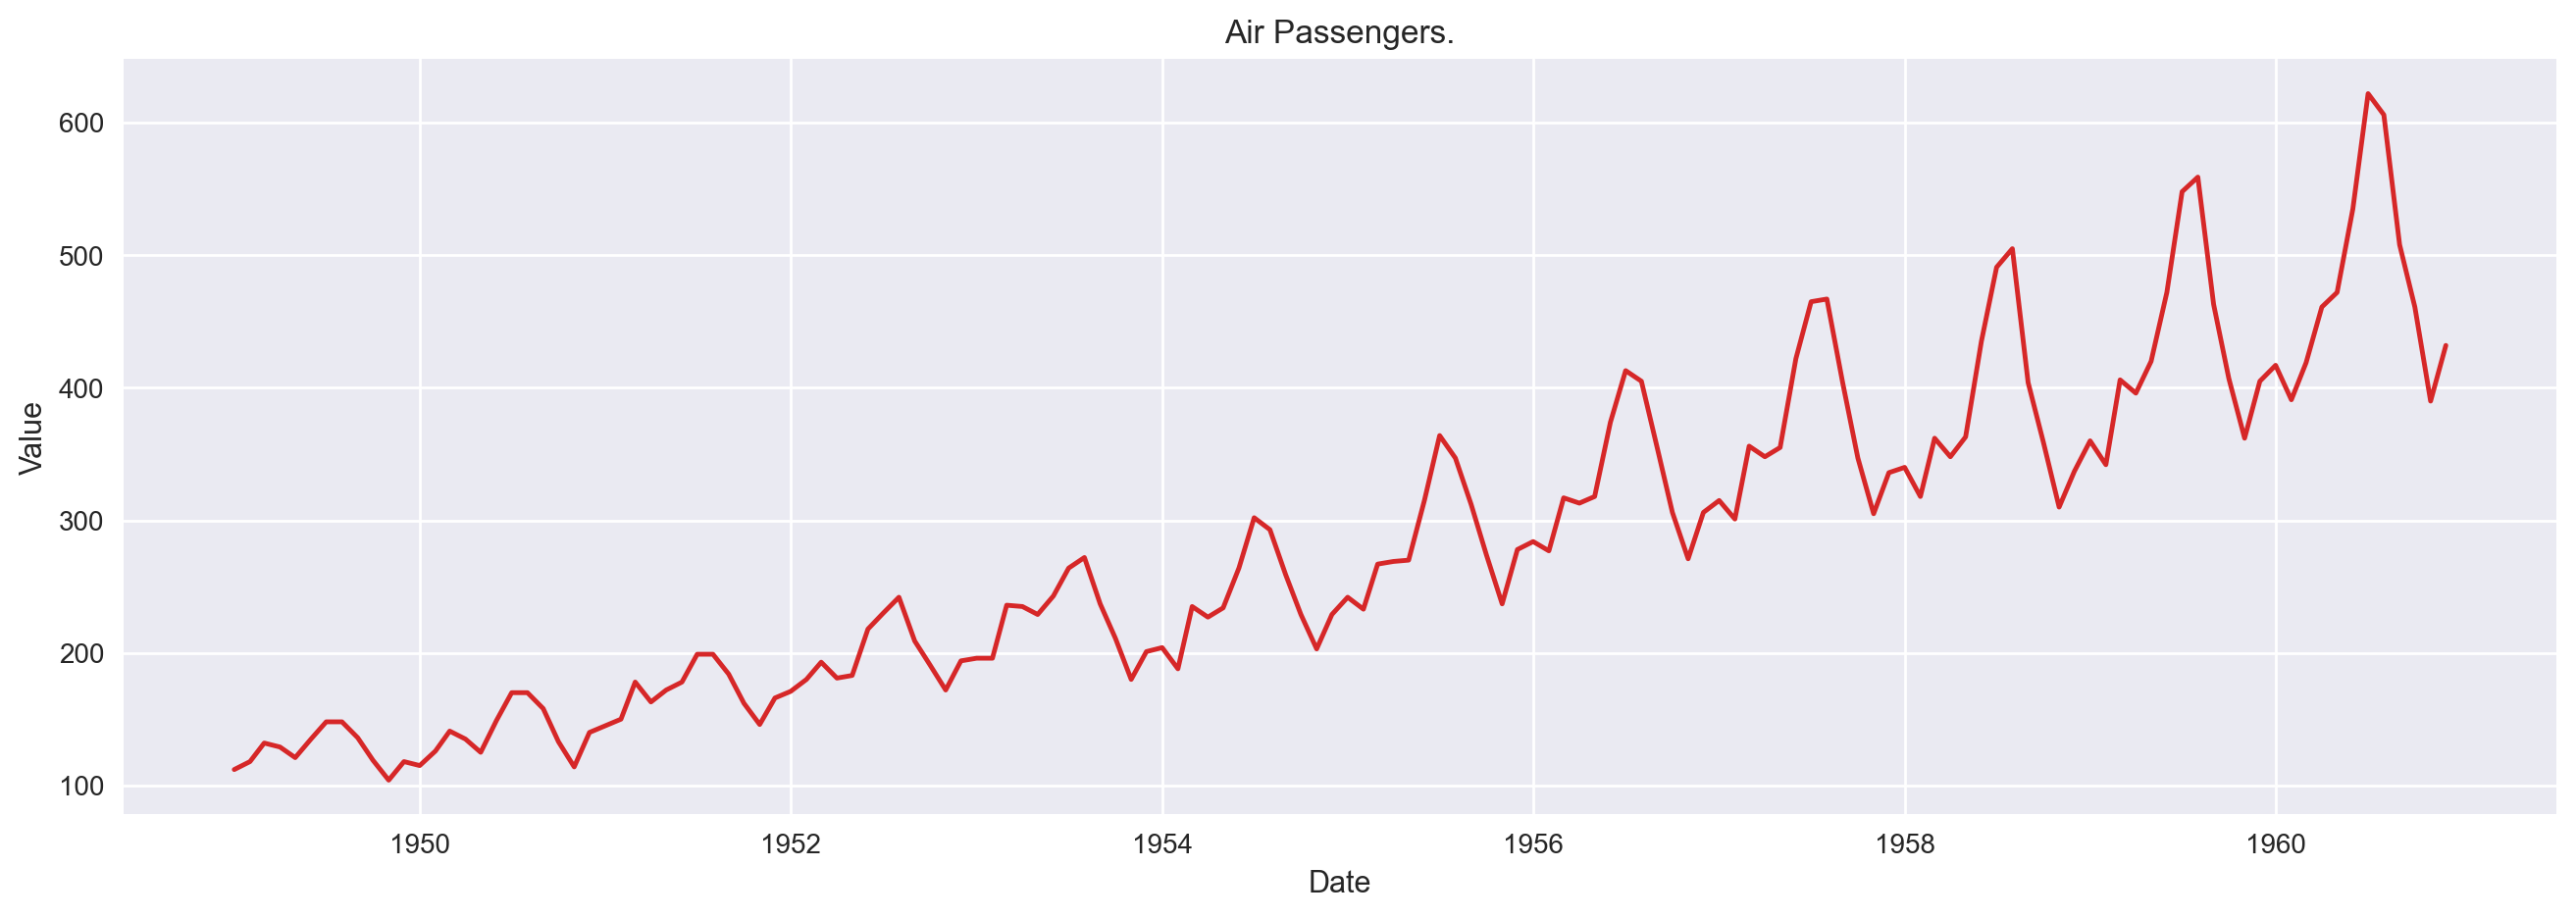

In [15]:
plot_df(passangers, x=passangers.reset_index().date, y=passangers.value, title='Air Passengers.') 

In [16]:
a10_df = pd.read_csv(Path(RESOURCES_PATH, "a10.csv"), parse_dates=['date'], index_col='date')

# Multiplicative Decomposition 
# `extrapolate_trend` takes care of any missing values 
# in the trend and residuals at the beginning of the series.
result_mul = seasonal_decompose(a10_df['value'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(a10_df['value'], model='additive', extrapolate_trend='freq')


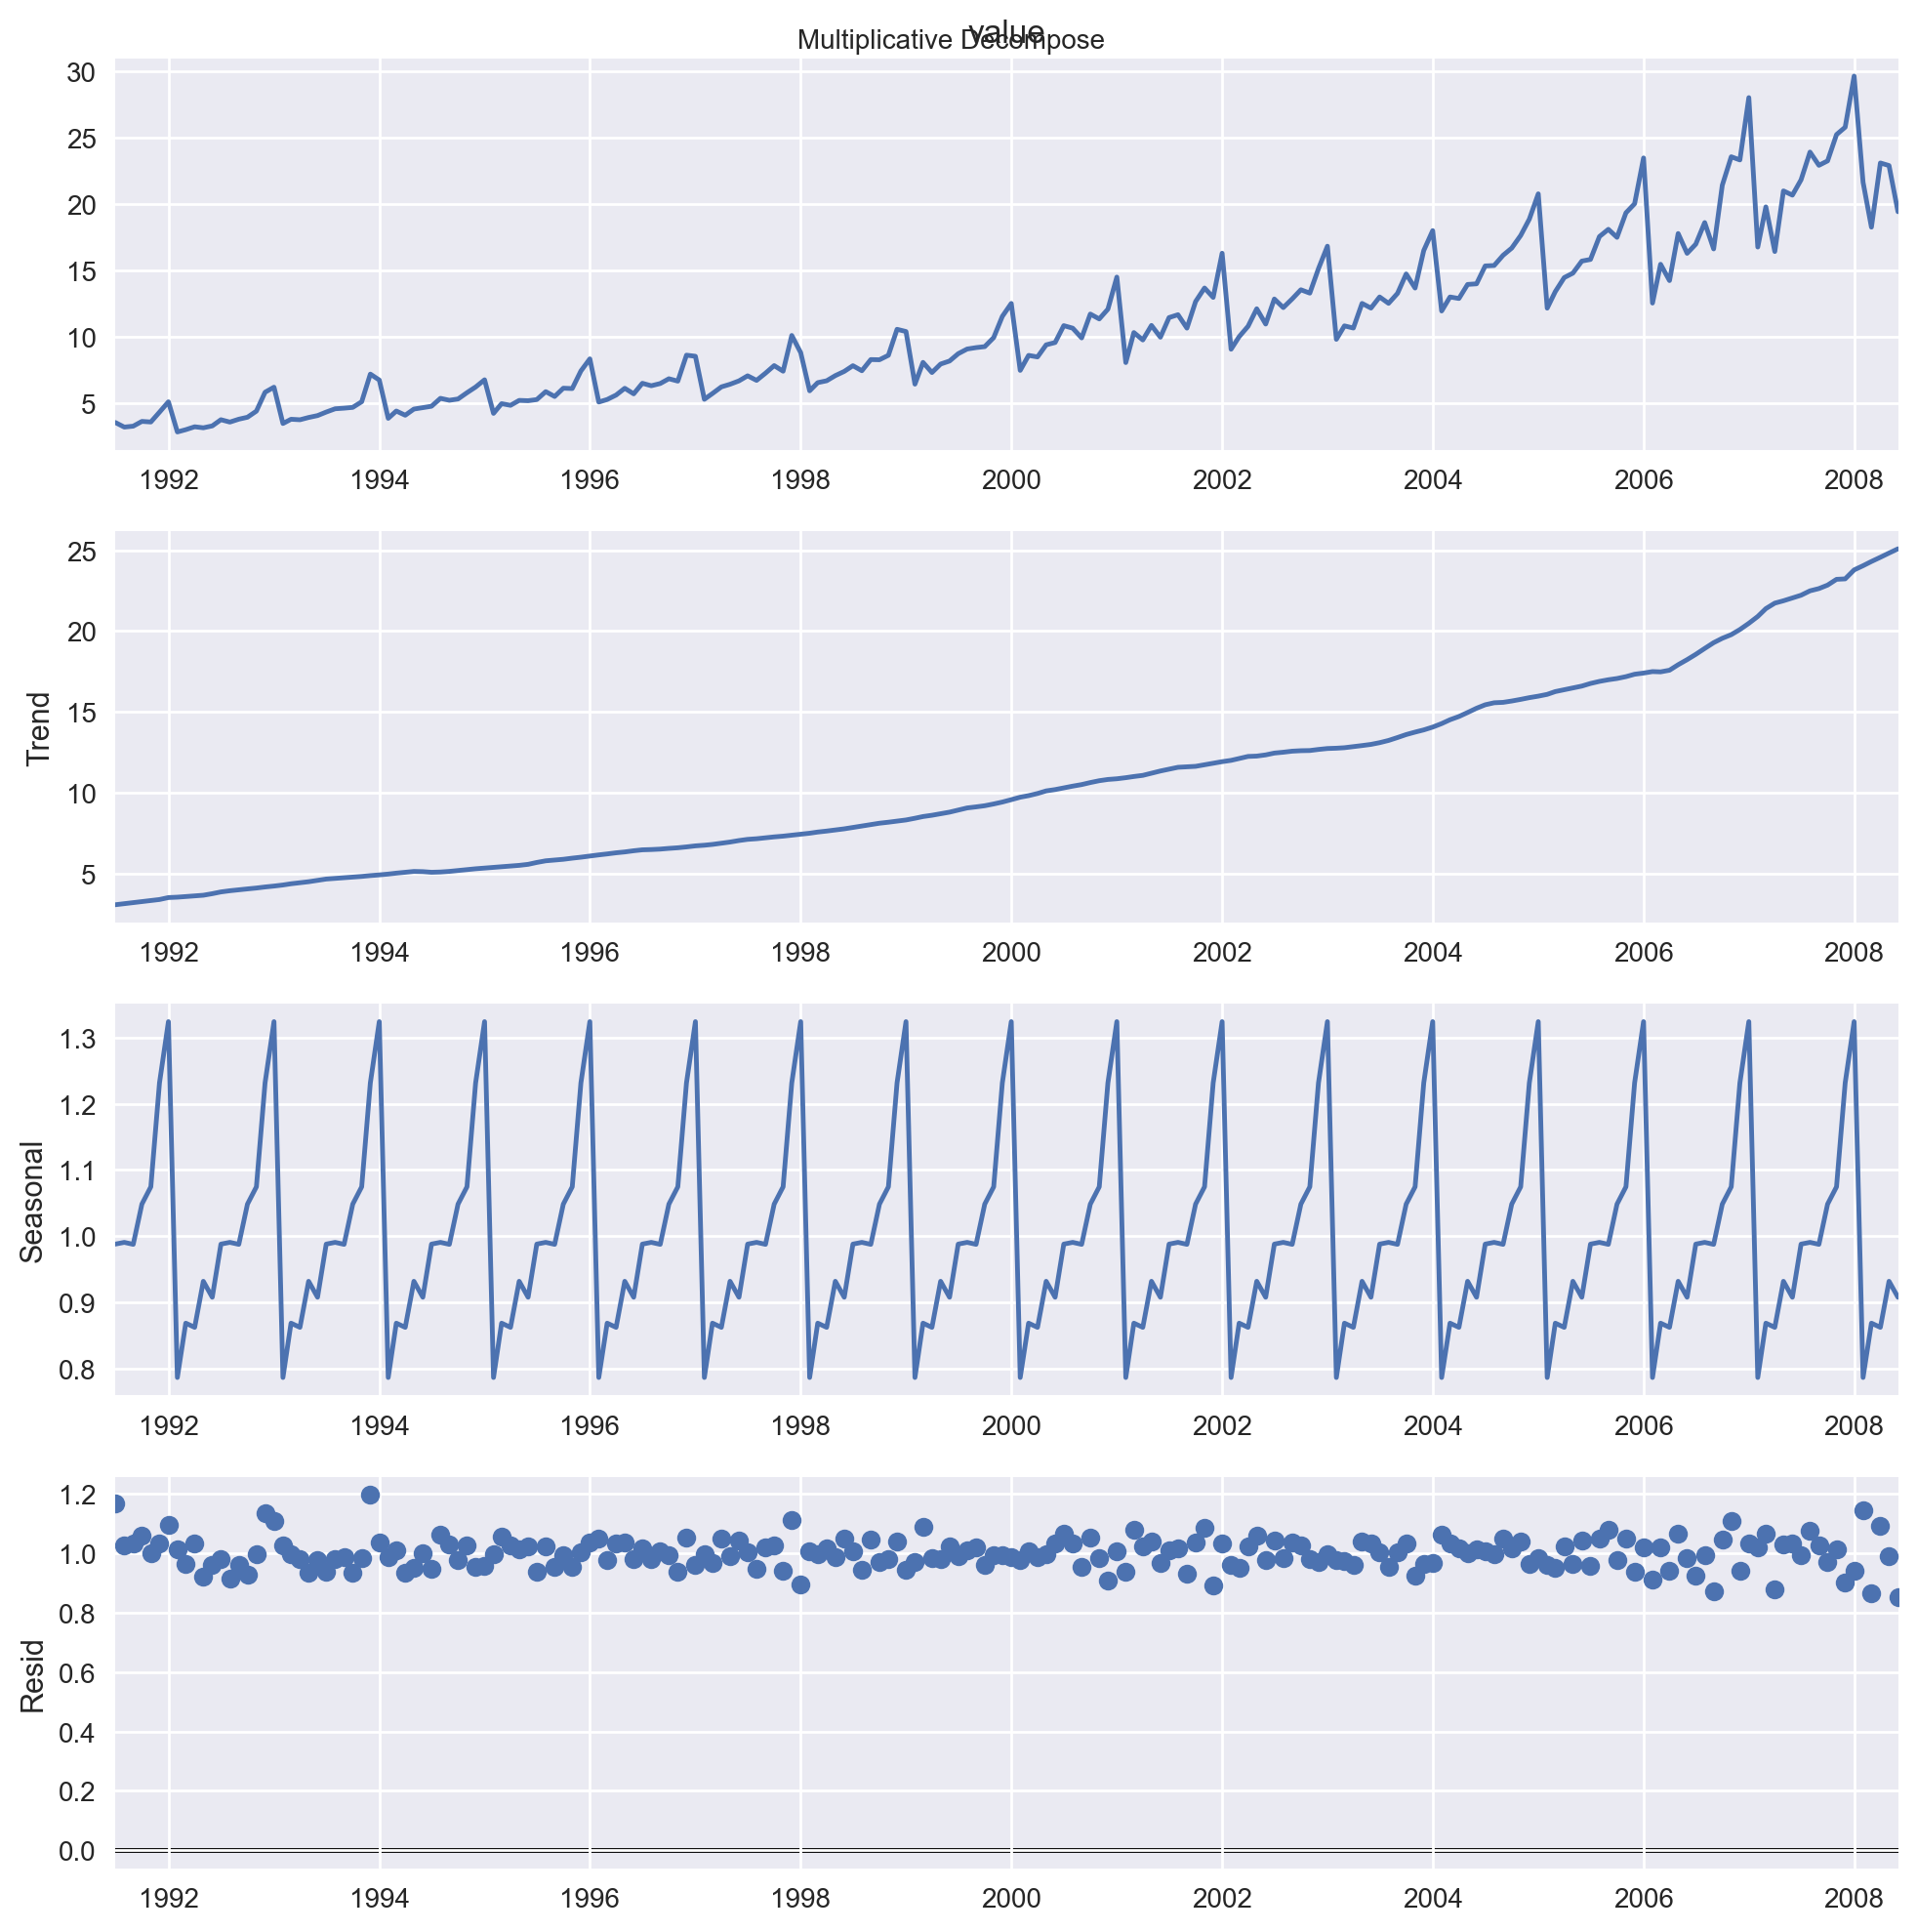

In [17]:
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=10)
plt.show()

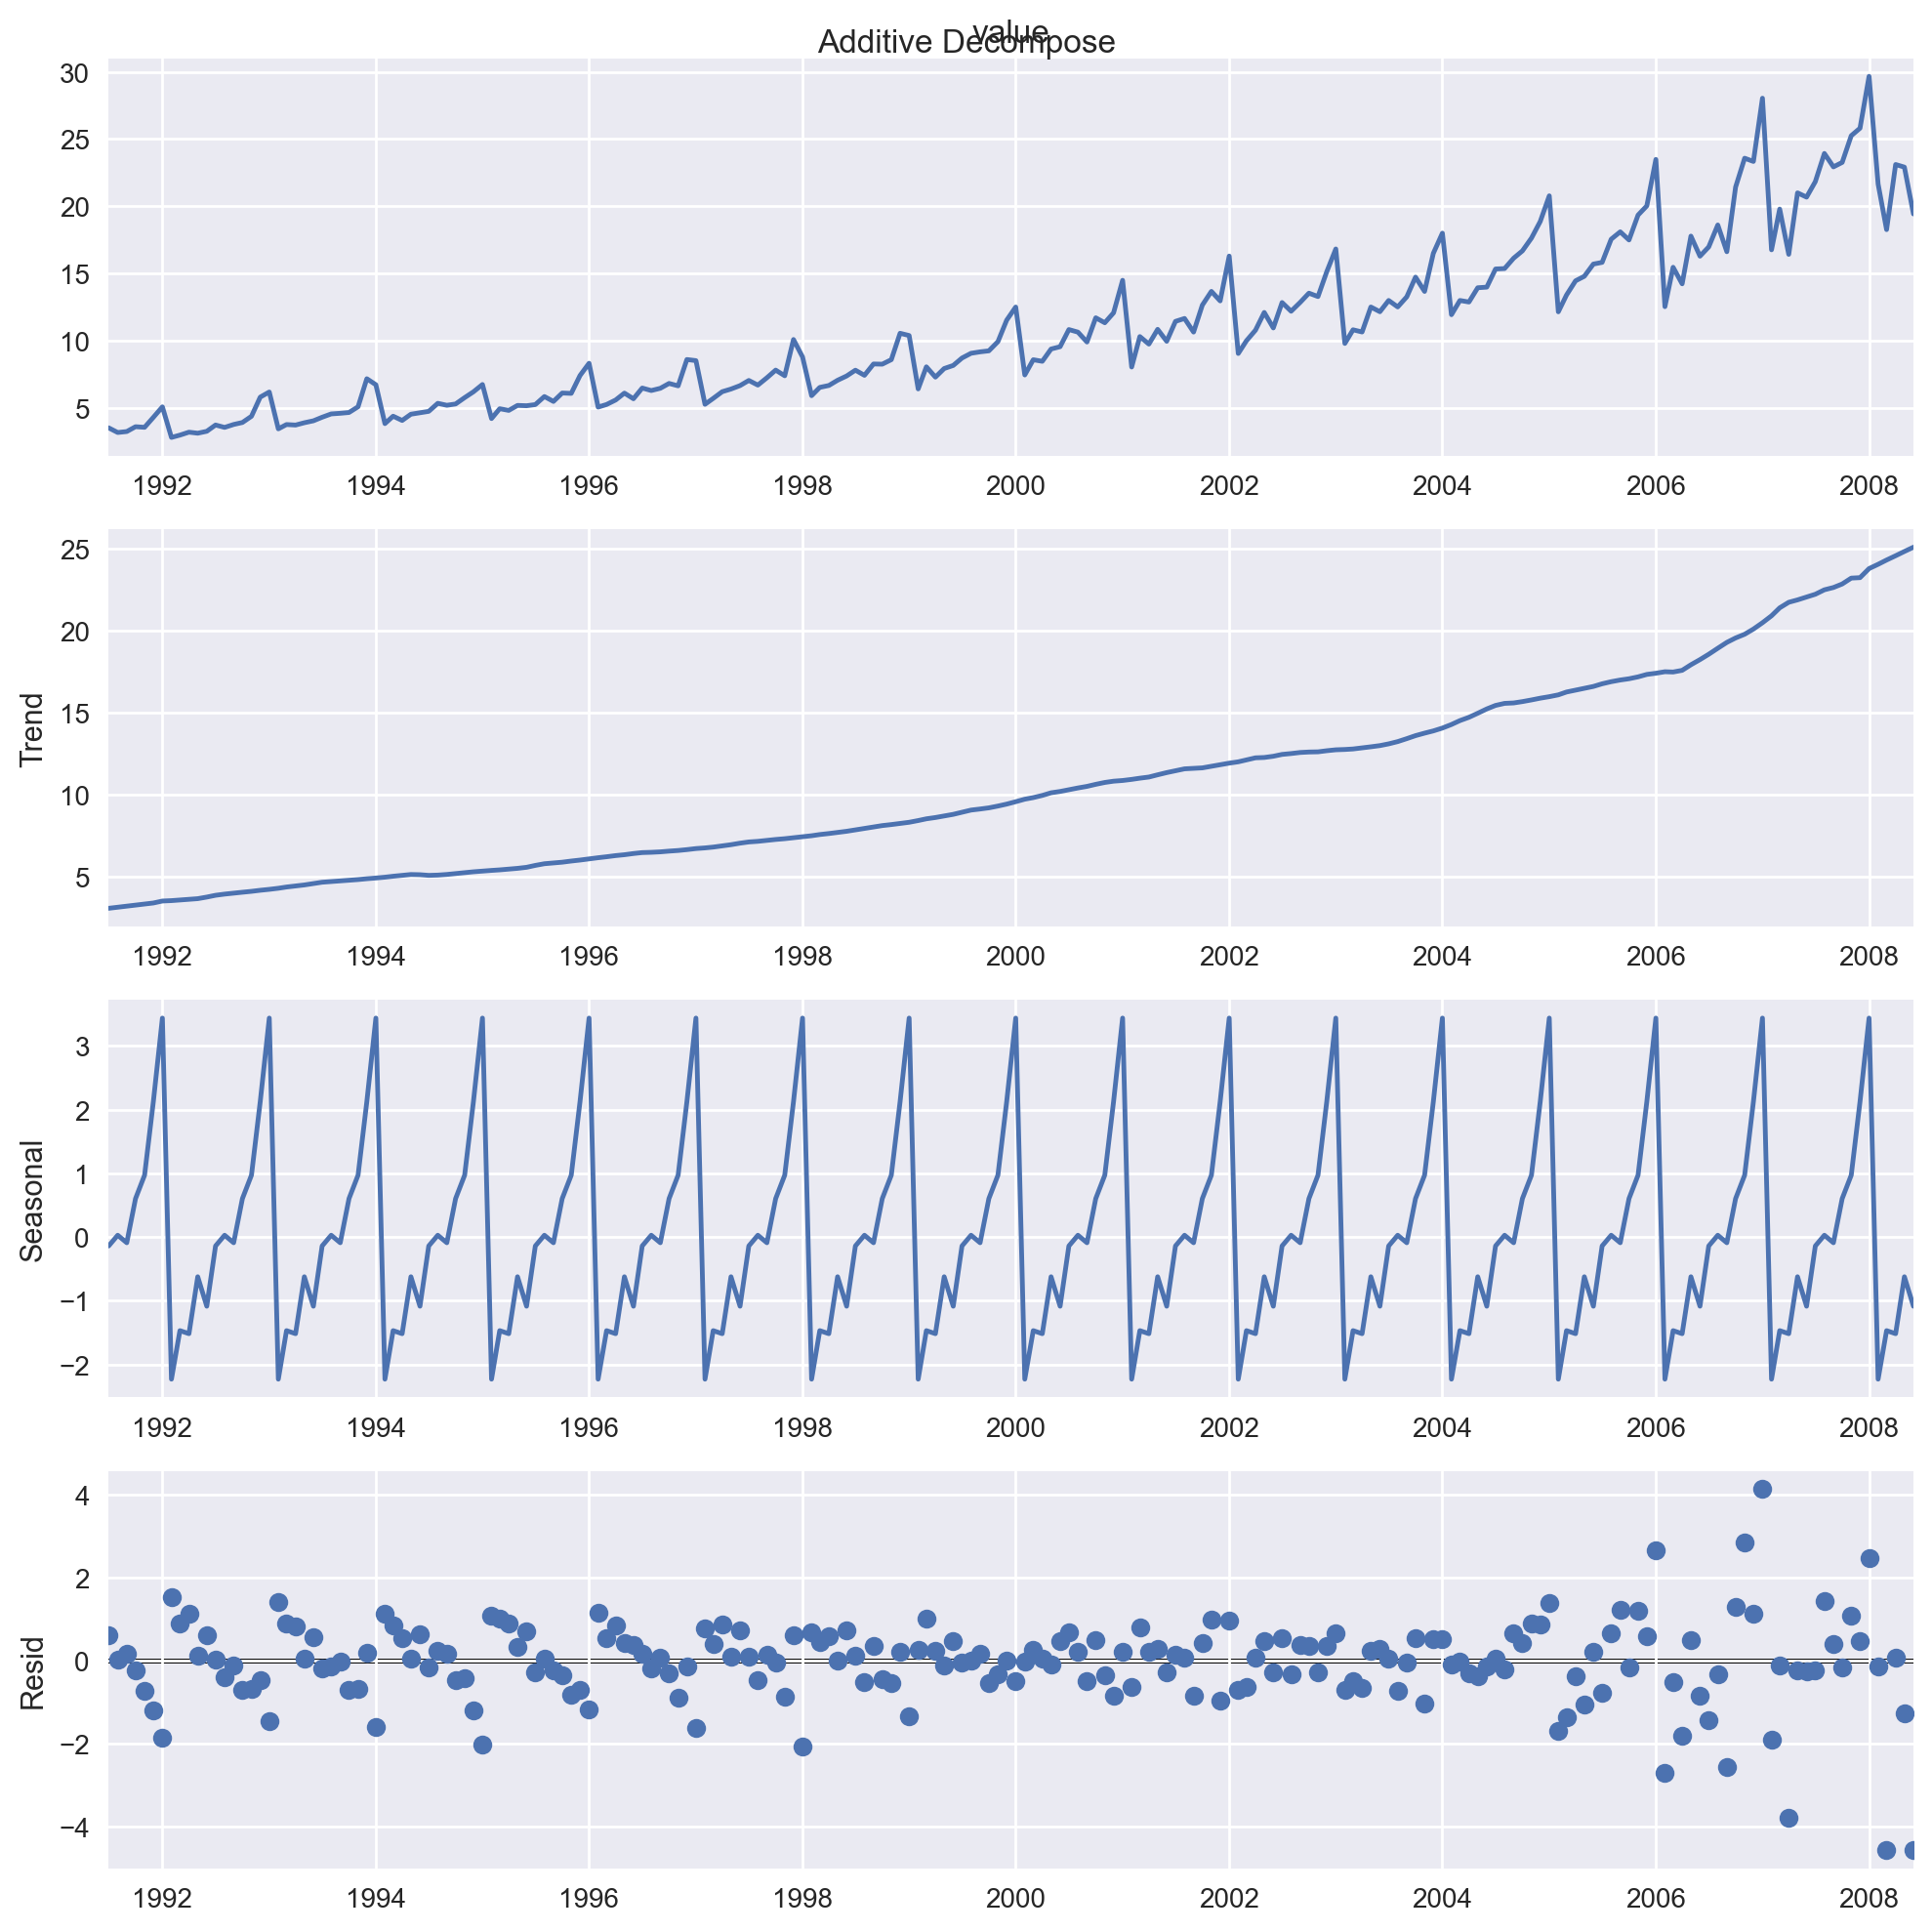

In [18]:
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=12)
plt.show()

The residuals of the additive decomposition has some pattern left over, while in the multiplicative decomposition it looks quite random, which is good since this is the irreducible error component. For this case, the multiplicative decomposition should be preferred.

In [19]:
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis=1)
df_reconstructed.columns = ['seasonality', 'trend', 'residual', 'actual_values']
df_reconstructed.head()

seasonality     trend  residual  actual_values
date                                                      
1991-07-01     0.987845  3.060085  1.166629       3.526591
1991-08-01     0.990481  3.124765  1.027745       3.180891
1991-09-01     0.987476  3.189445  1.032615       3.252221
1991-10-01     1.048329  3.254125  1.058513       3.611003
1991-11-01     1.074527  3.318805  0.999923       3.565869

It is possible to remove component from a time series.

To remove `trend` and `seasonality`, for example:

In [20]:
result_mul = seasonal_decompose(a10_df['value'], model='multiplicative', extrapolate_trend='freq')
detrended = a10_df.value - result_mul.trend
detrended_lsf = signal.detrend(a10_df.value)

a10_df['detrended'] = detrended
a10_df['detrended_lsf'] = detrended_lsf


Text(0.5, 1.0, 'Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')

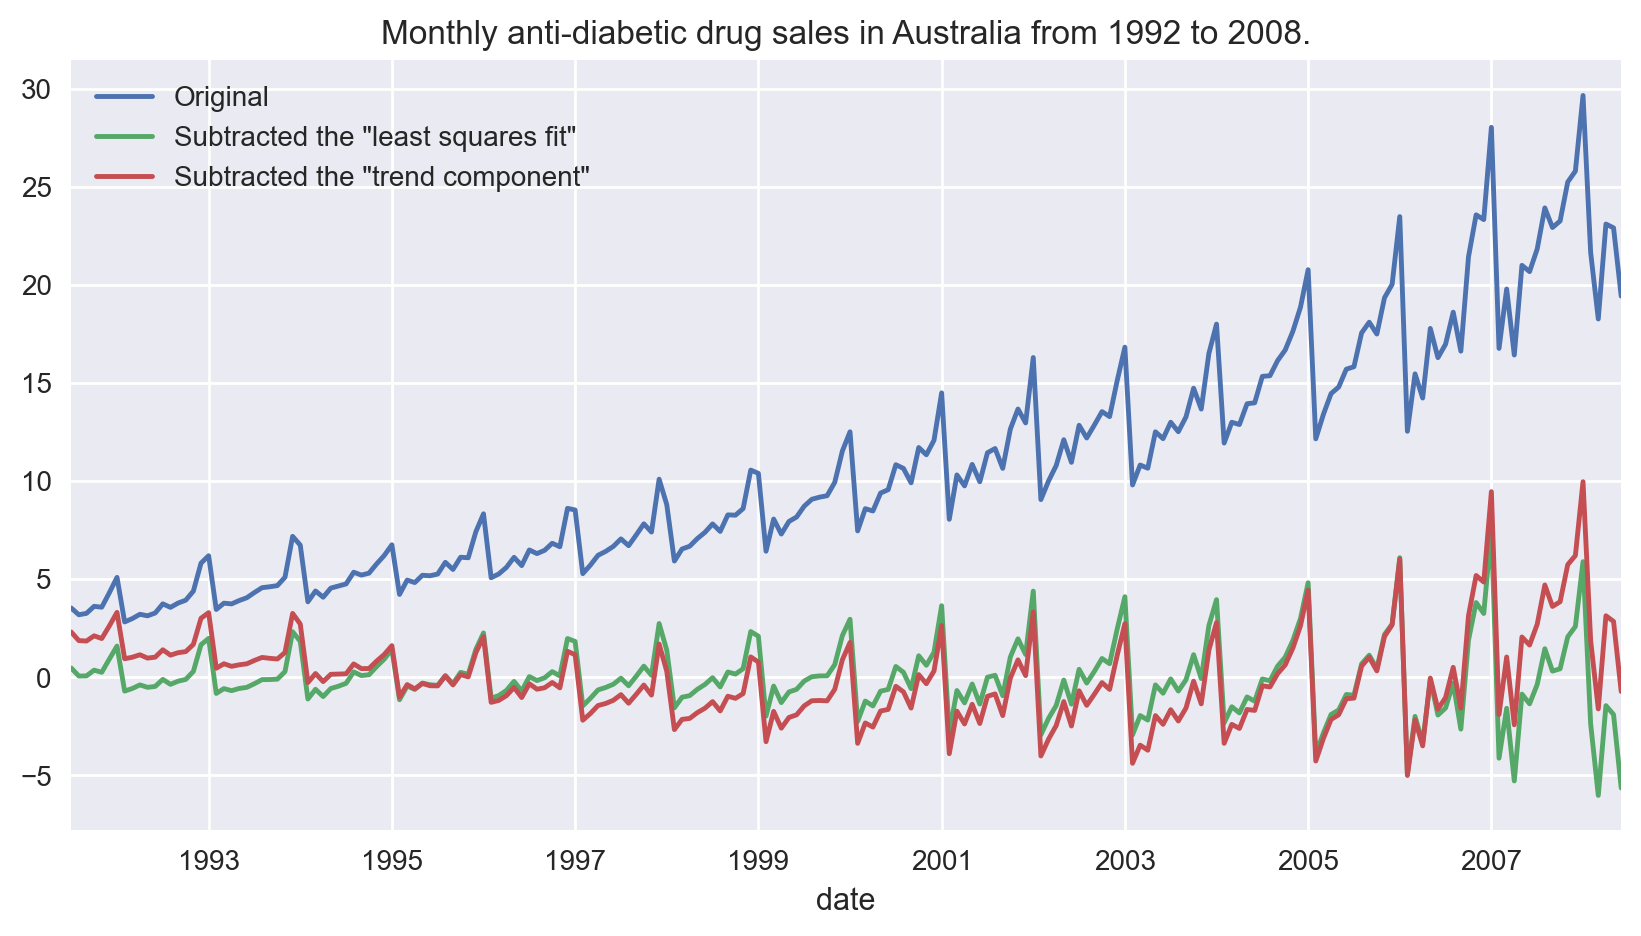

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
a10_df.value.plot(label='Original')
a10_df.detrended.plot(label='Subtracted the "least squares fit"')
a10_df.detrended_lsf.plot(label='Subtracted the "trend component"')
ax.legend()
plt.title("Monthly anti-diabetic drug sales in Australia from 1992 to 2008.", fontsize=12)

Remove `seasonality` component:

In [22]:
deseasonalized = a10_df.value / result_mul.seasonal
a10_df['deseasonalized'] = deseasonalized

Text(0.5, 1.0, 'Monthly anti-diabetic drug sales in Australia from 1992 to 2008.')

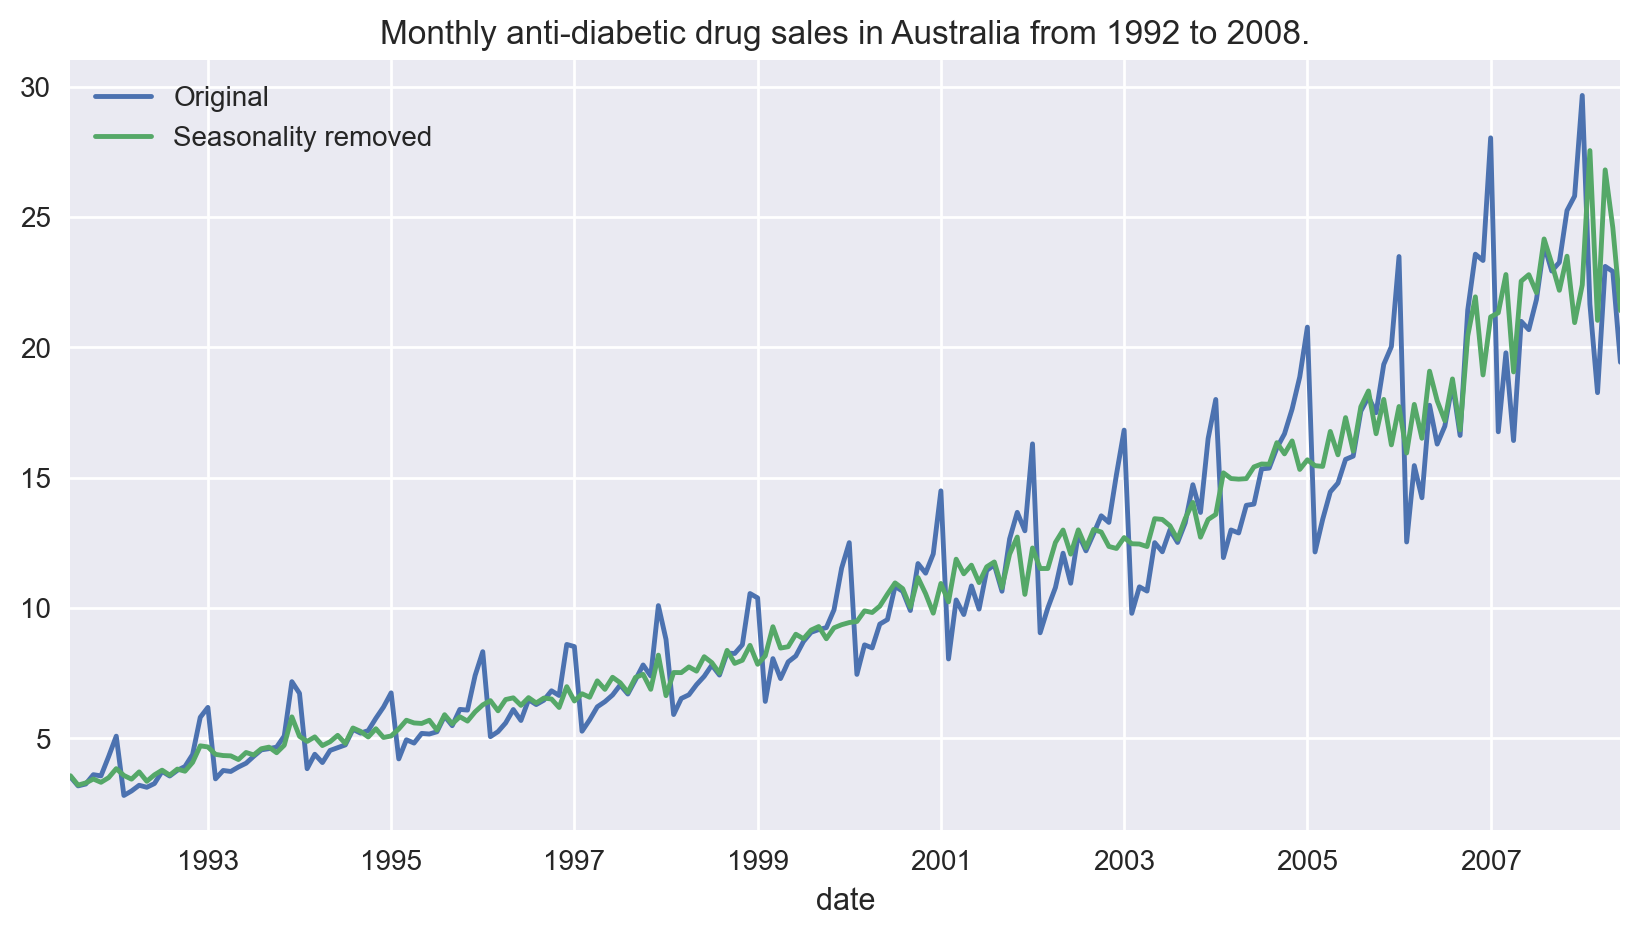

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
a10_df.value.plot(label='Original')
a10_df.deseasonalized.plot(label='Seasonality removed')
ax.legend()

plt.title("Monthly anti-diabetic drug sales in Australia from 1992 to 2008.", fontsize=12)

## Stationary VS non-stationary

The observations in a stationary time series are not dependent on time. Its means the statistical properties like variance, mean and autocorrelation are constant over time, and thus, there is no seasonal effect in a stationary series.

> In layman words: flat looking series, without trend, constant variance over time, a constant autocorrelation structure over time and no periodic fluctuations. [See Stationarity
](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc442.htm).

Trends can result in a varying mean over time, whereas seasonality can result in a changing variance over time, both which define a time series as being non-stationary, and thus providing a drift in the concepts a model may try to capture. Since several forecasting methods require a stationary series, you need to transform the series somehow to make it stationary. You can:

- should `difference` the series at least until it become stationary. The differenced data will contain one less point than the original data. Although you can difference the data more than once, one difference is usually sufficient. The number of times that differencing is performed is called the difference order.
- take the log of the series if it has non-constant variance
- take the `n-th` root of the series
- fit some type of curve to the data and then model the residuals from that fit, if the data contain a trend.
- combination of the above methods

After removing the trend the data should have a constant location and variance. You can verify that with a run sequence plot.

To verify if a series is stationary you can use `unit root` tests:

- `ADH test`: Augmented Dickey Fuller test, is fundamentally a statistical significance test with the null hypothesis the series `has unit root` (is **non-stationary**), with the alternative that there is no unit root. If the `pvalue` is above a critical size, then we cannot reject that there is a unit root. Thus, when the test statistic is **lower** than the critical values, you reject the null hypothesis and infer that the time series is stationary.
- `KPSS test`: Kwiatkowski-Phillips-Schmidt-Shin test, figures out if a time series is stationary around a mean or linear trend, or is non-stationary due to a unit root. It is a test for the null hypothesis that x is level or trend stationary. If the statistic is **greater** than the critical values (given alpha levels of 10%, 5% and 1%), then the null hypothesis is rejected.
- `PP test`:



A key difference betwee `ADF` and `KPSS` is the null hypothesis:
- `ADF`: series is **non**-stationary.
- `KPSS`: series is stationary.

When interpreting the results, thing of the `p-value` carefully since it should be used in opposite fashion in each of these tests.


> The number of unit roots contained in the series corresponds to the number of differencing operations required to make the series stationary.


### `ADF` test



In [24]:
result = adfuller(a10_df.value.values, regression='c', autolag='AIC')

# from the docs:
# regression{“c”,”ct”,”ctt”,”n”}
# Constant and trend order to include in regression.
# “c” : constant only (default).
# “ct” : constant and trend.
# “ctt” : constant, and linear and quadratic trend.
# “n” : no constant, no trend.
#
# autolag{“AIC”, “BIC”, “t-stat”, None}

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'used lag: {result[2]}')
print(f'num observations: {result[3]}')
for key, value in result[4].items():
    print(f'Critial Values: {key}, {value}')

ADF Statistic: 3.1451856893067514
p-value: 1.0
used lag: 15
num observations: 188
Critial Values: 1%, -3.465620397124192
Critial Values: 5%, -2.8770397560752436
Critial Values: 10%, -2.5750324547306476


Breaking down the results' object:


- `adf`: The test statistic. Critical value of the data.
- `pvalue`: MacKinnon’s approximate p-value based on MacKinnon (1994, 2010). Probability that null hypothesis will not be rejected(p-value)
- `usedlag`: The number of lags used.
- `nobs`: The number of observations used for the ADF regression and calculation of the critical values.
- `critical values` : a dictionary with the critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010).
- `icbest` float: The maximized information criterion if autolag is not None.


> Remember: when the test statistic is **lower** than the critical value shown, you reject the null hypothesis and infer that the time series is stationary.


Observations:
- The `adf` value (`3.1451`) is higher than all CV for t-values test statistics `{'1%': -3.465620397124192, '5%': -2.8770397560752436, '10%': -2.5750324547306476}`, the null hypothesis cannot be rejected.
- The `p-value = 1.0` is greater than `0.05` (considering 5% significance level, or 95% confidence interval), the null hypothesis cannot be rejected.

Thus, we cannot reject the null hypothesis. Consequently, this series is **non stationary**, meaing it has relation with time.

In layman's words:
> Since the p-value is 1.0, the correct interpretation is “There is 100% that my model has unit root (is non stationary)”.



A random sequence of numbers is usually stationarity. Let's see the example below:


ADF Statistic: -11.011086900322066
p-value: 6.322868559179706e-20
used lag: 0
num observations: 99
Critial Values: 1%, -3.498198082189098
Critial Values: 5%, -2.891208211860468
Critial Values: 10%, -2.5825959973472097


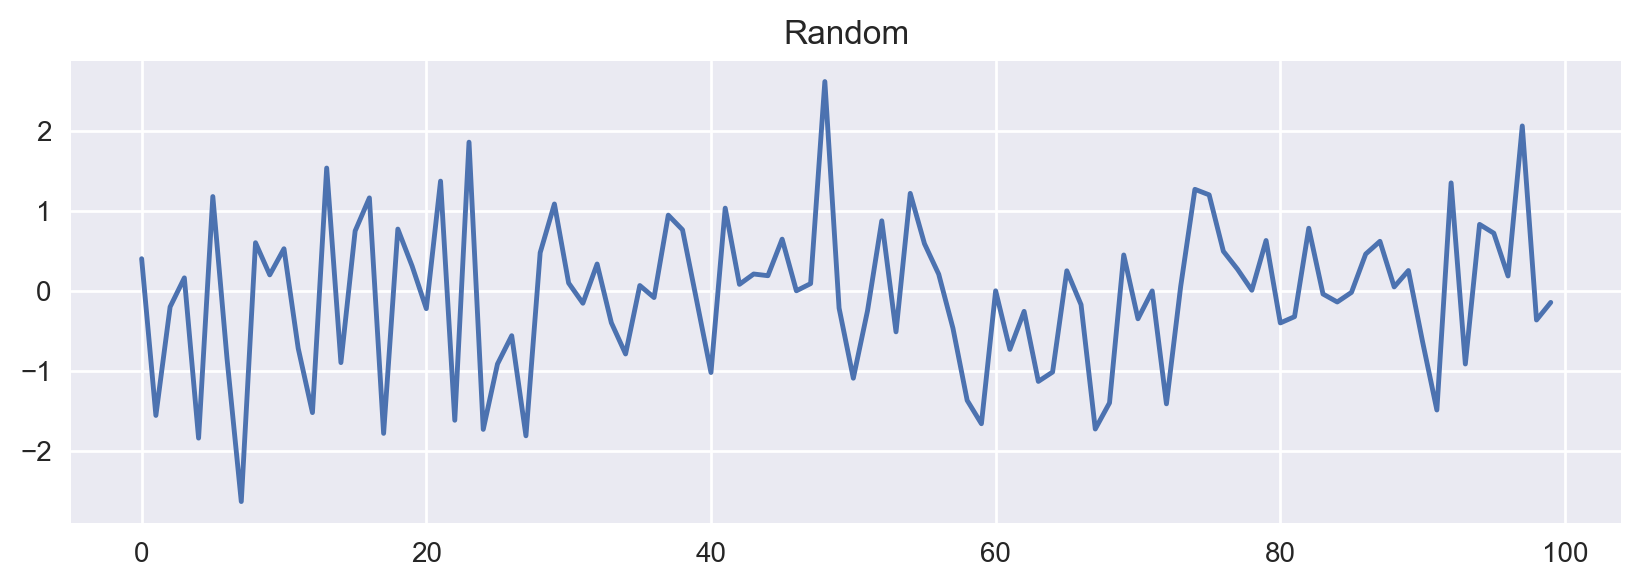

In [25]:
# ADF test on random numbers
rand_series = np.random.randn(100)
fig, axes = plt.subplots(figsize=(10,3))
plt.plot(rand_series);
plt.title('Random');

result = adfuller(rand_series, autolag='AIC')

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'used lag: {result[2]}')
print(f'num observations: {result[3]}')
for key, value in result[4].items():
    print(f'Critial Values: {key}, {value}')

- The `adf = -10.0799` which are smaller than any of the critival values at `{-3.4981, -2.8912, -2.5825}`. 
- The `p-value << 0.05`.

Therefore, we can reject the null hypothesis and conclude this series **is stationary**.


### `KPSS` test
Consider now the `KPSS` test.

> Remember: $H_0$ the series is stationary.

The `p-value`calculated by `KPSS` test is a probability score, which we can use to decide whether to reject the null hypothesis or not. If the `p-value` is less than a predefined significance level alpha (typically `0.05`), we reject the null hypothesis.

Considering a significance level of `0.05`:
- if `p-value >= 0.05` the $H_0$ is accepted, and the series is **stationary**. 
- if `p-value < 0.05` the $H_0$ is rejected, and the series is **non-stationary**. 

Moreover, the test statistic should be greater than the critical values to reject the null hypothesis. 


In [26]:
result = kpss(a10_df.value.values, regression='c')
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[3].items():
    print(f'Critial Values: {key}, {value}')

KPSS Statistic: 2.0131256386303327
p-value: 0.01
Critial Values: 10%, 0.347
Critial Values: 5%, 0.463
Critial Values: 2.5%, 0.574
Critial Values: 1%, 0.739


/Users/jeanmetz/Library/Caches/pypoetry/virtualenvs/time-series-forecast-9nvPIdxb-py3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(



$H_0$ is rejected since:
- the `p-value = 0.01 < 0.05`.
- the `KPSS` value is greather than the critical values.

Therefore, the series is **non-stationary**.

`KPSS` is prone to `Type I` errors. Combining both `KPSS` and `ADF` tests could be an alternative to have higher confidence in identifying if a series is stationary.


## Autocorrelation


>Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals.

>Autocorrelation measures the relationship between a variable’s current value and its past values.

>An autocorrelation of +1 represents a perfect positive correlation, while an autocorrelation of negative 1 represents a perfect negative correlation.


Why is this useful?

- Help us uncover hidden patterns in our data.
- Help us select the correct forecasting methods.
- Help identify seasonality in our time series data.
- help select appropriate ARIMA models (if analyzing the `autocorrelation function` (ACF) and `partial autocorrelation function` (PACF) in conjunction).


Assumption: the series is **weakly stationary**, which means no systematic change in the mean, variance, and no systematic fluctuation. 

So when performing ACF it is advisable to remove any trend present in the data and to make sure the data is stationary.

Let's look at the original data again:


In [27]:
a10_df = pd.read_csv(Path(RESOURCES_PATH, "a10.csv"), parse_dates=['date'], index_col='date')

<AxesSubplot: xlabel='date'>

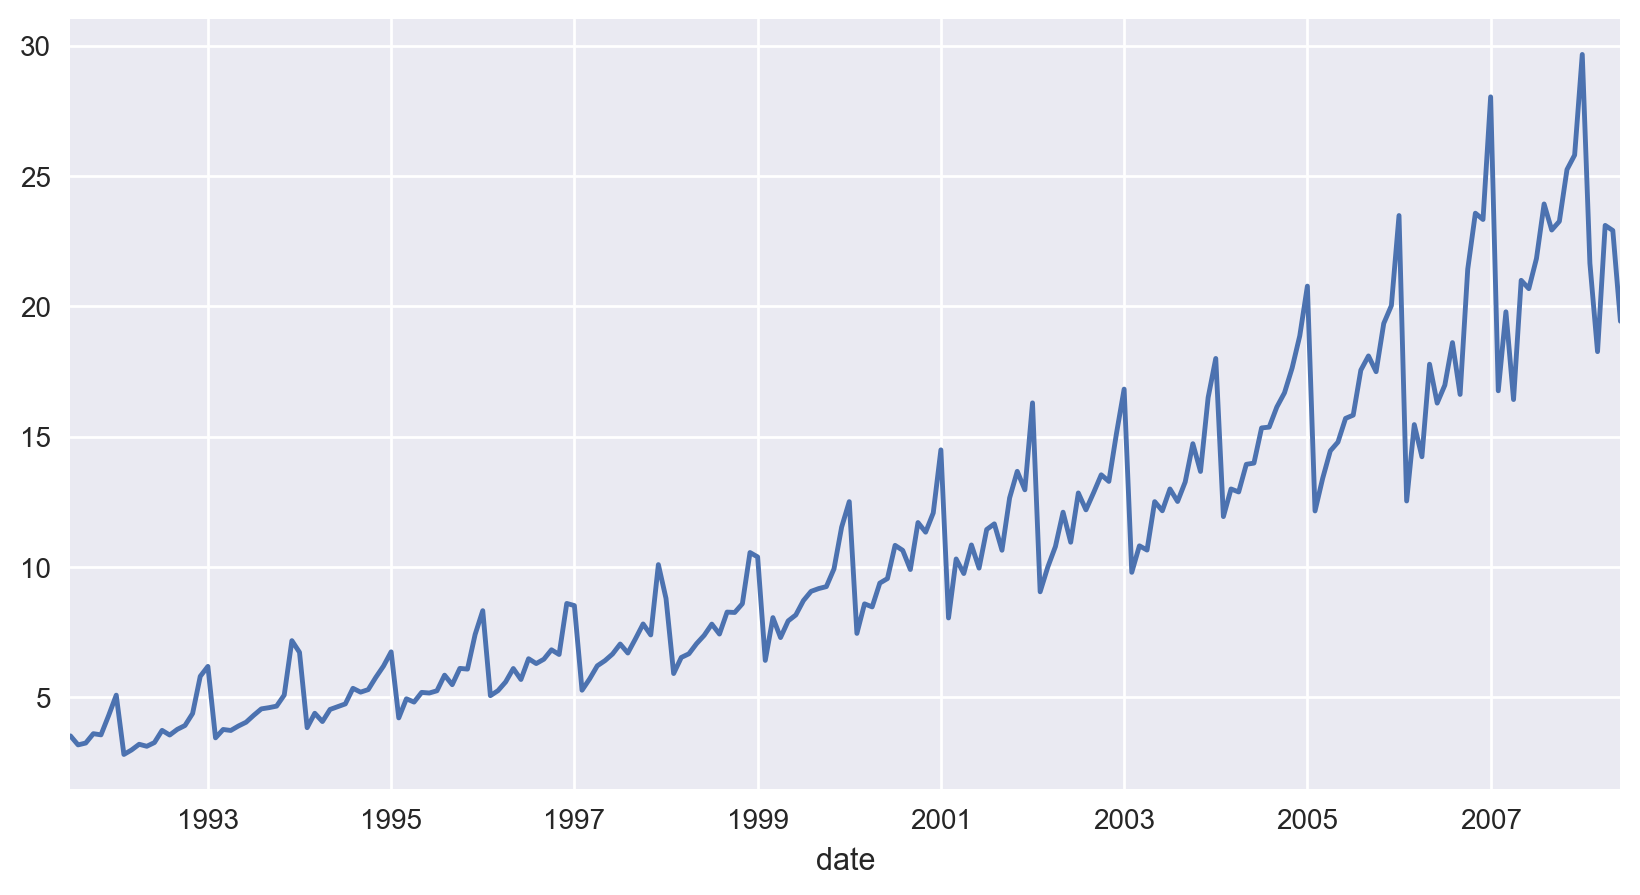

In [28]:
a10_df.value.plot(figsize=(10,5))

To verify there is seasonality in the series, you can use `autocorrelation function (ACF)` plot, which should show a few periodical peaks in case of seasonality.

Bear in mind this first chat is using the original data with all the components in it.

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

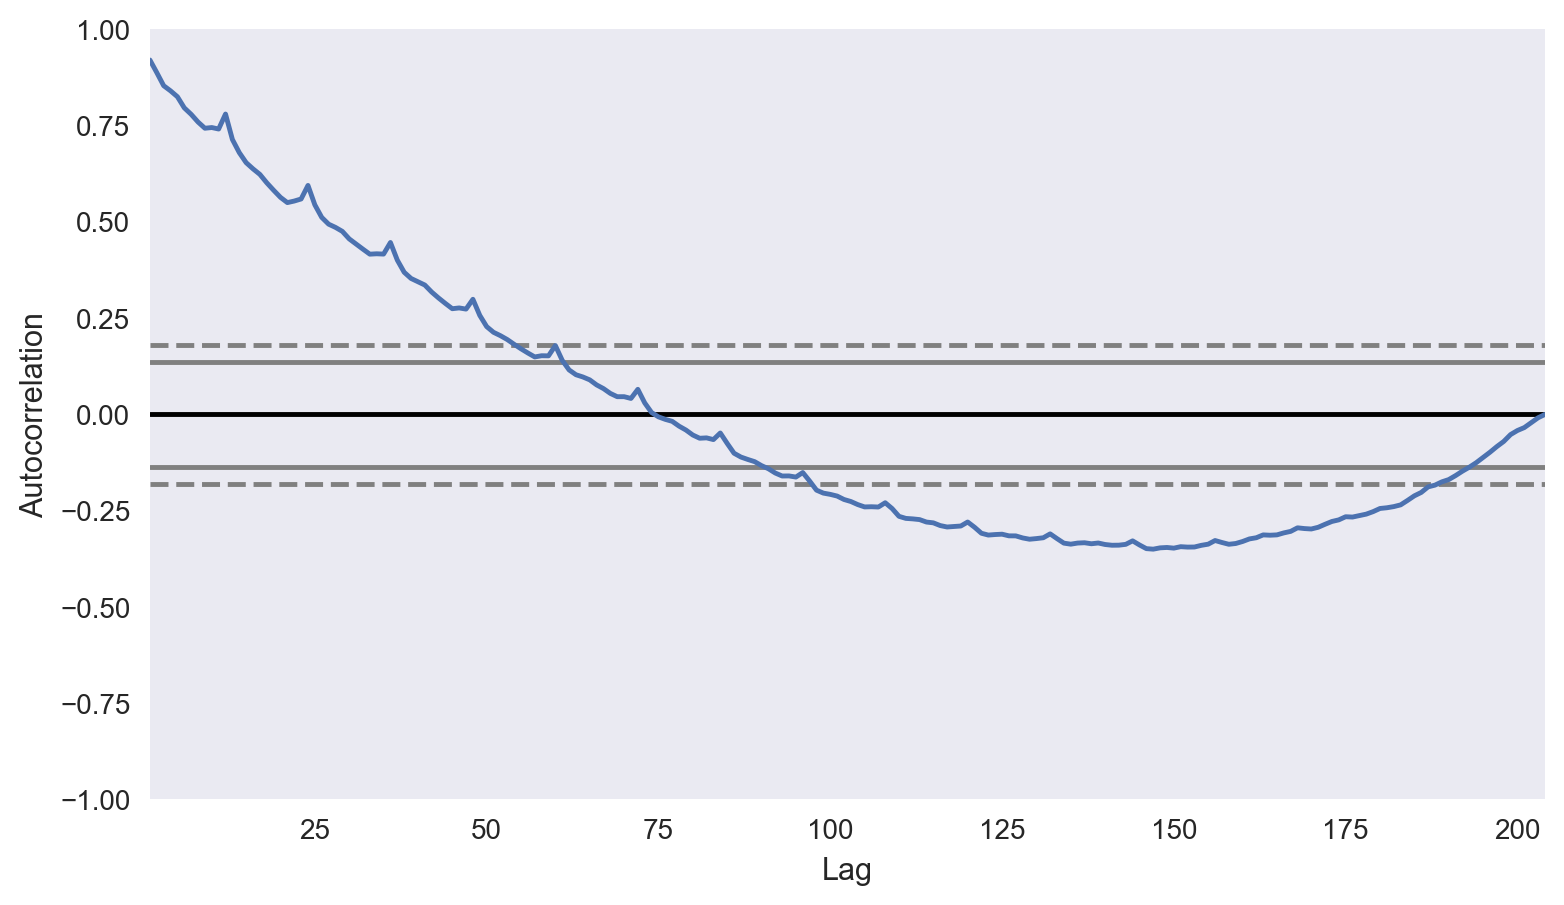

In [29]:
plt.rcParams.update({'figure.figsize':(9,5)})
autocorrelation_plot(a10_df.value)

The horizontal lines in the plot correspond to 95% and 99% confidence bands.

The dashed line is 99% confidence band.

Let's decompose the series and show the ACF plot again.

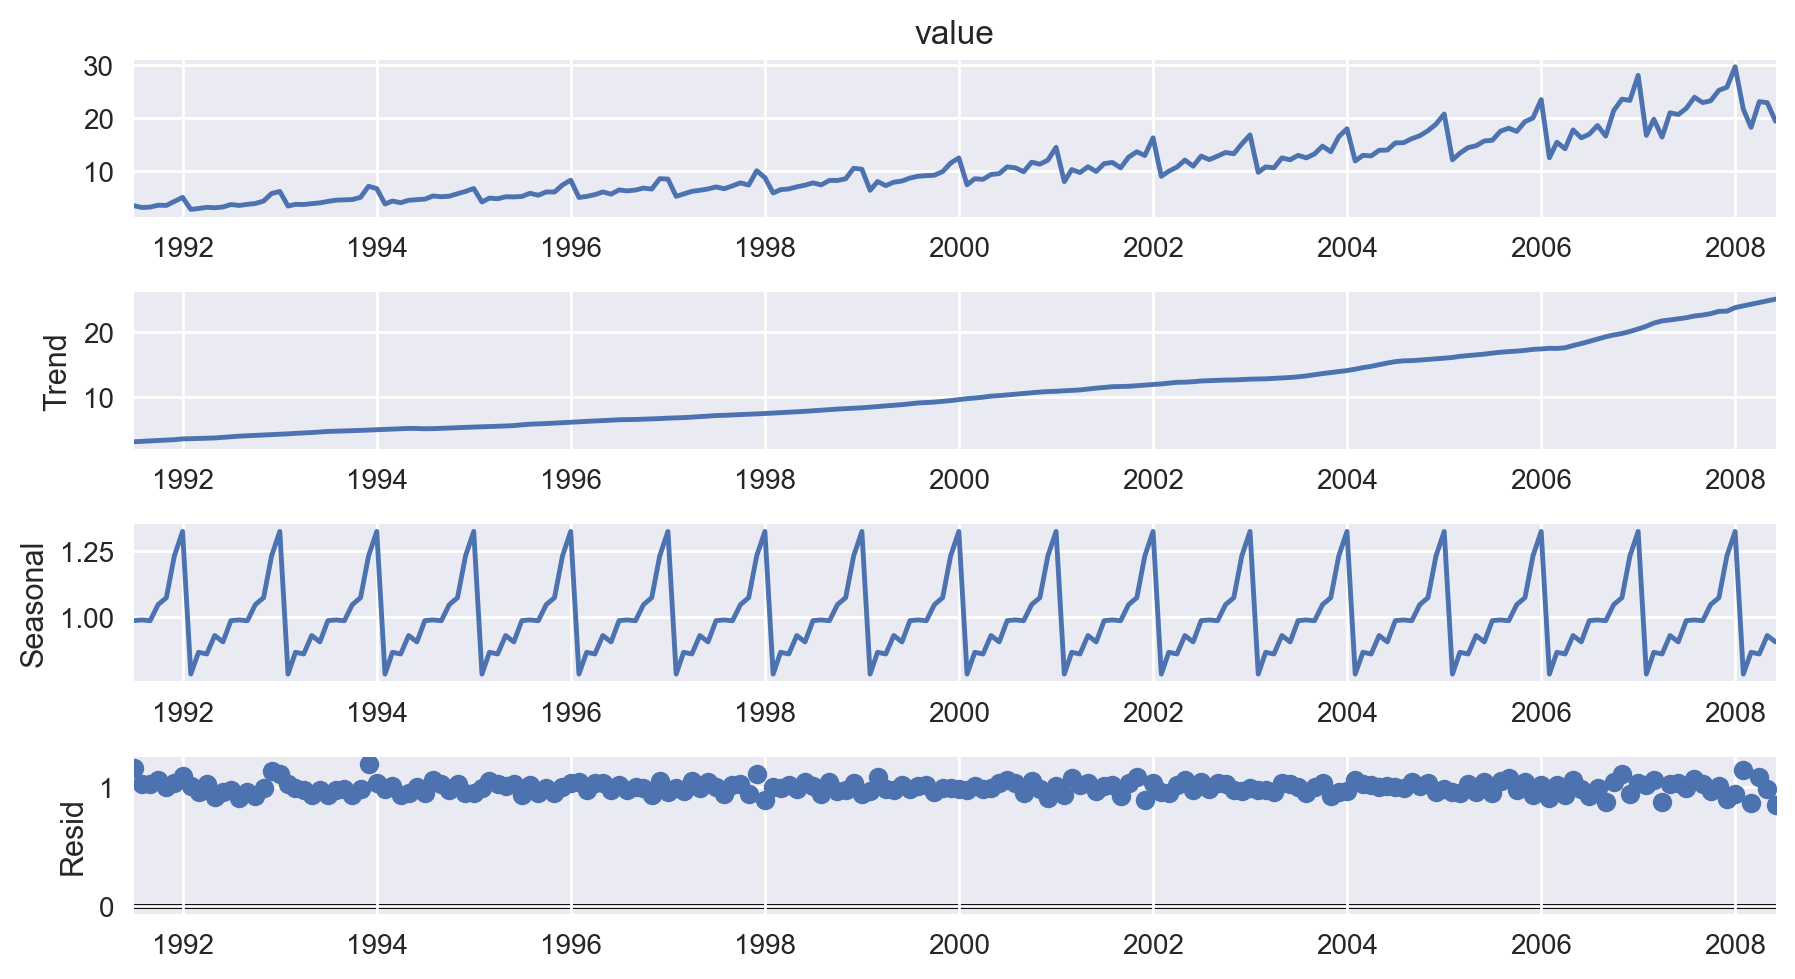

In [30]:
result_mul = seasonal_decompose(a10_df['value'], model='multiplicative', extrapolate_trend='freq')
result_mul.plot()
plt.show()

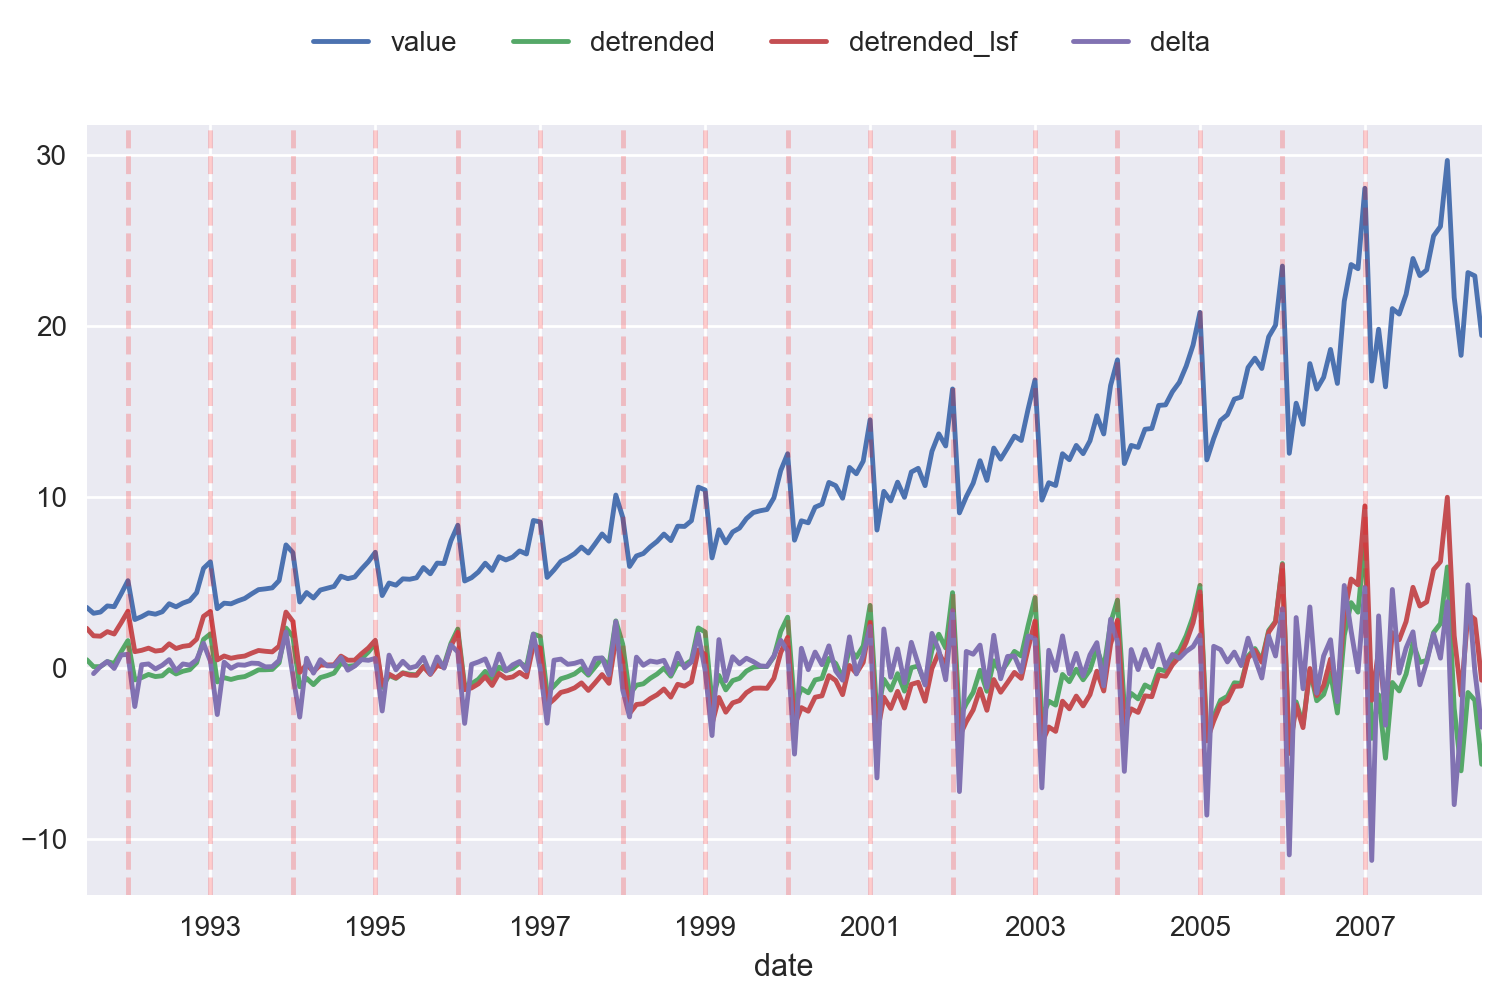

In [31]:
detrended = a10_df.value - result_mul.trend
detrended_lsf = signal.detrend(a10_df.value)

a10_df['detrended'] = detrended
a10_df['detrended_lsf'] = detrended_lsf
a10_df["delta"] = a10_df.value.diff()

ax = a10_df.plot()
ax.legend(ncol=5, 
          loc='upper center',
          bbox_to_anchor=(0.5, 1.0),
          bbox_transform=plt.gcf().transFigure)
for yr in range(1991, 2008):
    ax.axvline(pd.to_datetime(str(yr)+"-01-01"), color ="red", linestyle = "--", alpha = 0.2)
plt.show()

In [32]:
a10_df

value  detrended  detrended_lsf     delta
date                                                     
1991-07-01   3.526591   0.466506       2.302565       NaN
1991-08-01   3.180891   0.056126       1.863561 -0.345700
1991-09-01   3.252221   0.062776       1.841586  0.071330
1991-10-01   3.611003   0.356878       2.107064  0.358782
1991-11-01   3.565869   0.247064       1.968625 -0.045134
...               ...        ...            ...       ...
2008-02-01  21.654285  -2.383114       1.862669 -8.011071
2008-03-01  18.264945  -6.033513      -1.619975 -3.389340
2008-04-01  23.107677  -1.451839       3.129452  4.842732
2008-05-01  22.912510  -1.908064       2.840981 -0.195167
2008-06-01  19.431740  -5.649893      -0.733094 -3.480770

[204 rows x 4 columns]

`autocorrelation_plot` function does not accept `NaN`s. Thus:

In [33]:
a10_df.delta.iloc[0] = 0.

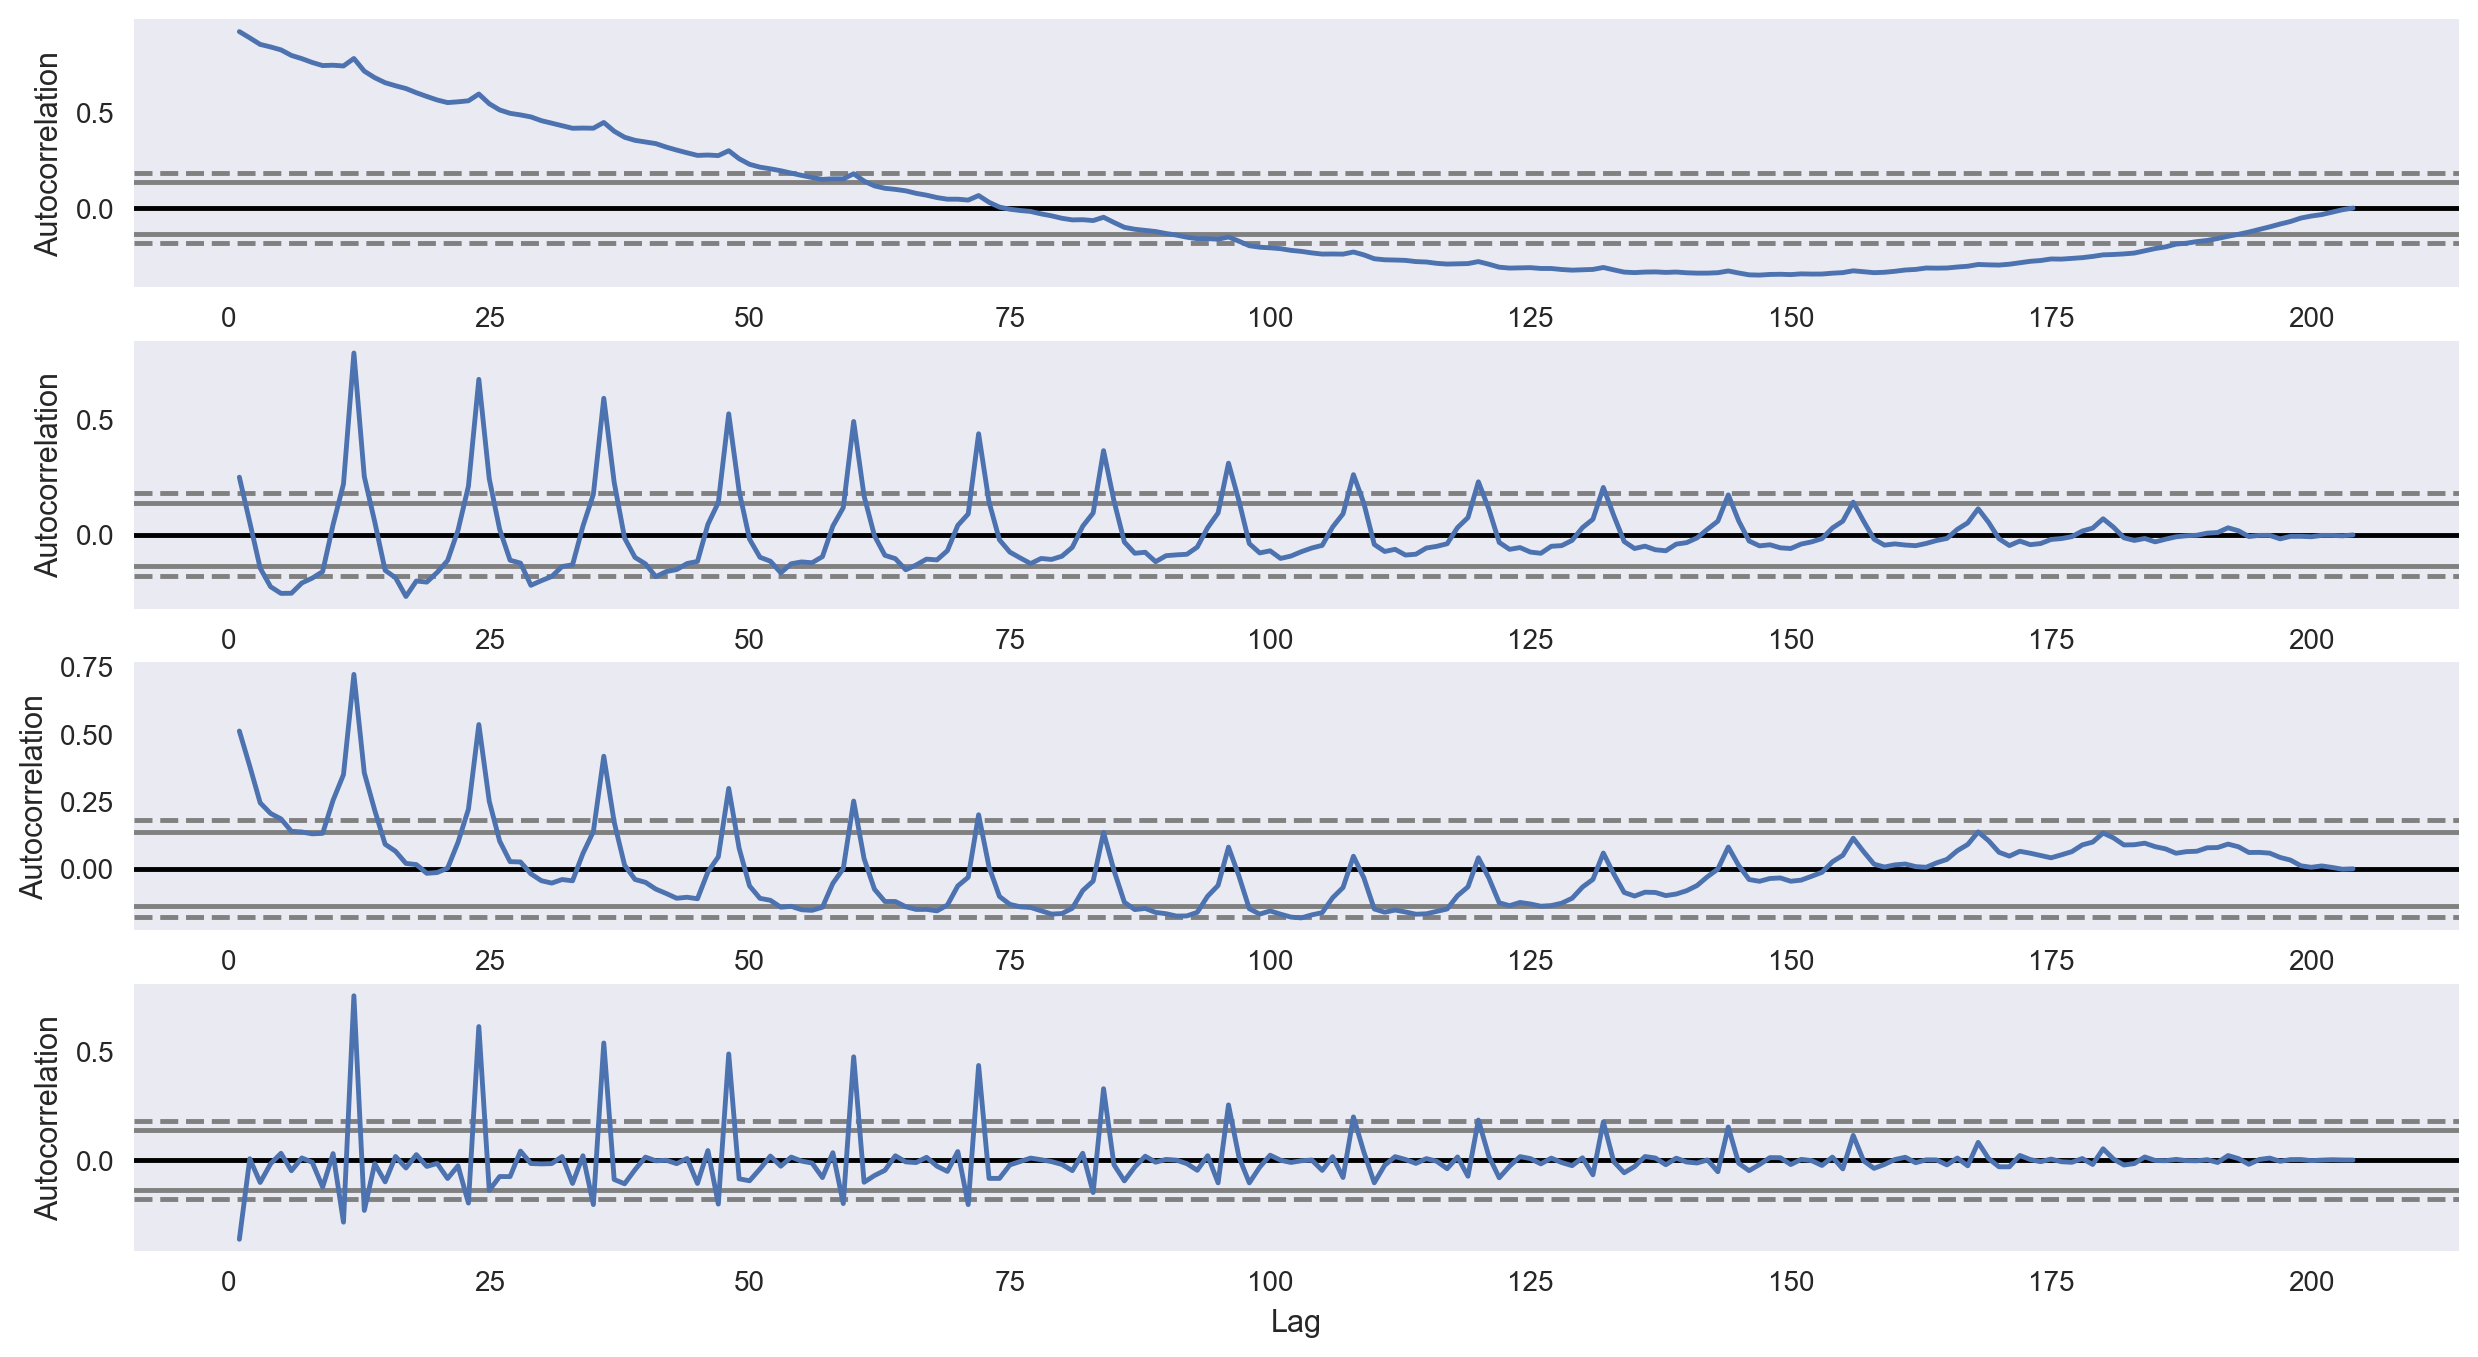

In [34]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,8))
autocorrelation_plot(a10_df.value, ax1)
autocorrelation_plot(a10_df.detrended, ax2)
autocorrelation_plot(a10_df.detrended_lsf, ax3)
autocorrelation_plot(a10_df.delta, ax4)
plt.show()

We can calculate the autocorrelation with `Pandas.Sereis.autocorr()` function,
which returns the value of the Pearson correlation coefficient.

The Pearson correlation coefficient is a measure of the linear correlation between two variables. The Pearson correlation coefficient has a value between -1 and 1, where `0` is no linear correlation, `>0` is a  positive correlation, and `<0`  is a negative correlation.

In [35]:
[a10_df.value.autocorr(lag=l) for l in range(1, 10)]

[0.9288874358833361,
 0.909318912755459,
 0.8884482109044975,
 0.882069149999957,
 0.8780411300705447,
 0.8757140255735408,
 0.8773221519602279,
 0.8769188183384274,
 0.8768871646557265]

These values are very close to 1.0, which indicates that there is **high correlation** in these lags.

And what if you want to implement your own `autocorr` function?
Below is a simplified (non-optmial performance) implementation, which computers the auto correlation value for each given lag.

In [36]:
def auto_corr(series: pd.Series, nlags = 2):
    """
    Autocorrelation of series given the number of lags
    
    Returns
        array: autocorrelation coefficients for lags [nlags, 0]
    """
    def auto_corr_for_lag(series_values, lag):
        values = np.asarray(series_values)
        mean_value = values.mean()
        delta_mean = values[lag:] - mean_value
        lagged_delta_mean = values[:-lag] - mean_value
        numerator = sum(delta_mean * lagged_delta_mean)
        sum_squared_diff = np.sum((values - mean_value) ** 2)
        return numerator / sum_squared_diff
        
    acf = [auto_corr_for_lag(series, lag=i) for i in range(1, nlags + 1)]
    return np.asarray([1] + acf)



The `statsmodels` package also provides an implementation of this method. We can use it to validate our implementation:

In [37]:
print(f"auto_corr: {auto_corr(a10_df.value, nlags=10)}")
print()
# sanity test: check against statsmodel
print(f"statsmodels acf: {tsaplots.acf(a10_df.value, nlags=10)}")

auto_corr: [1.         0.92056815 0.88782519 0.85385862 0.84052841 0.82523769
 0.79629658 0.77950157 0.75953251 0.74337588 0.74521347]

statsmodels acf: [1.         0.92056815 0.88782519 0.85385862 0.84052841 0.82523769
 0.79629658 0.77950157 0.75953251 0.74337588 0.74521347]


Observe these values confirm the results obtained with Pearson correlation. They are close to 1.0, and thus suggest there is **high correlation** in these lags.

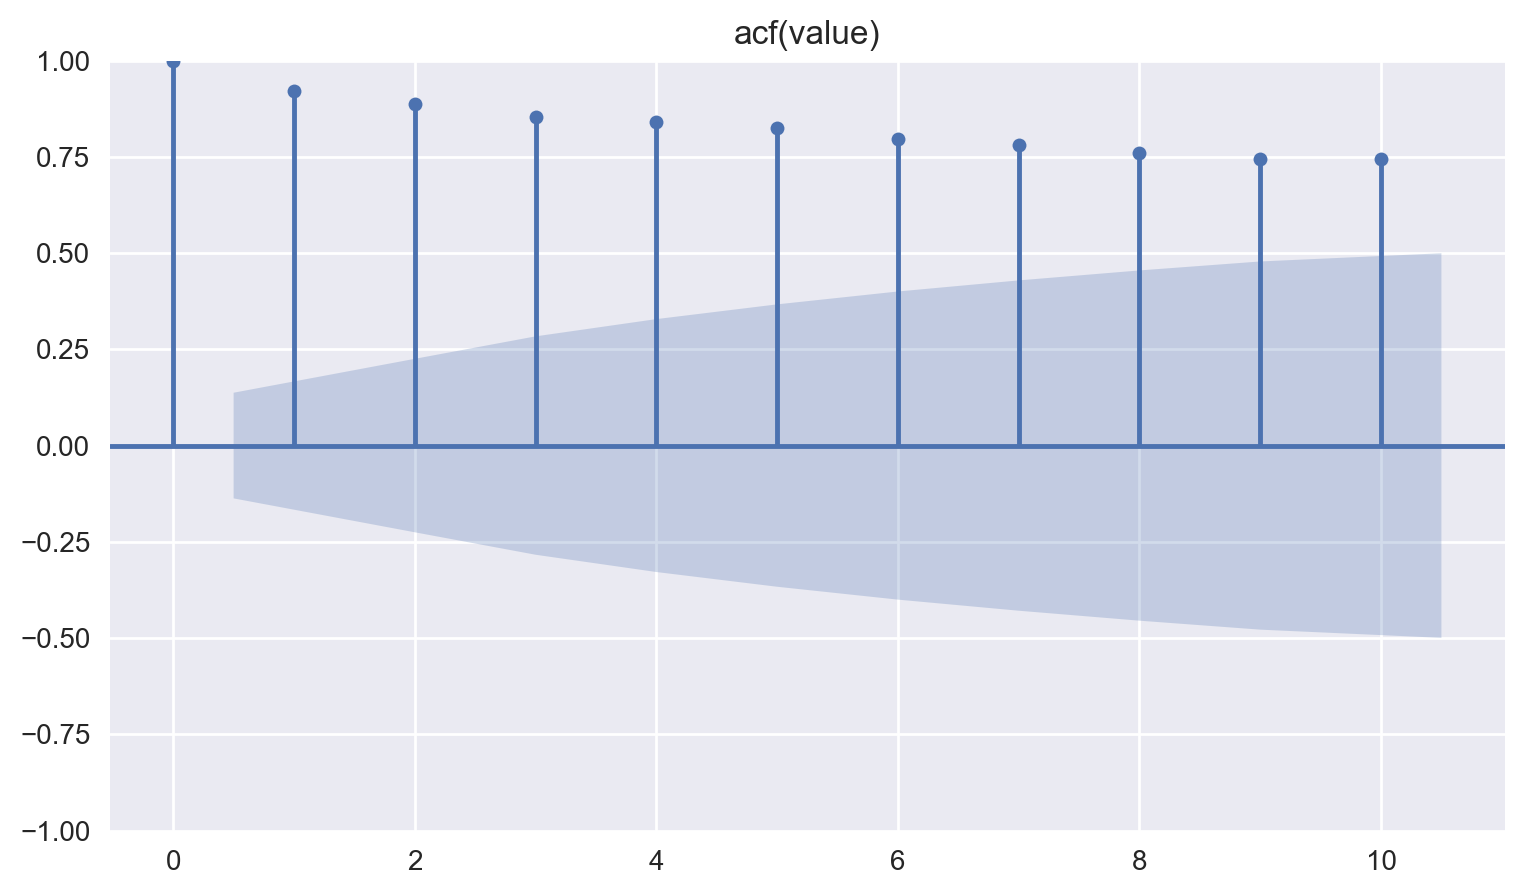

In [38]:
plot_acf(a10_df.value, lags=10, title="acf(value)")
plt.show()

The plot shows the lag value along the x-axis and the correlation on the y-axis between -1 and 1. The confidence intervals are drawn as the "shaded cone".

**Remember** the presence of seasonality would yield **high autocorrelation**. Also, keep in mind that values for the `ACF` are within (default) 95% confidence interval (represented by the solid line) for lags > 0.

In this chart all data points fall outside the shaded area indicating autocorrelation with a strong statistical significance.

However, they do not tell us the whole story. 
You could indentify correlation at `lag=1`, but maybe no at `lag=15` or `lag=40`. Thus, it’s a good idea to make an `autocorrelation plot` to compare the values of the autocorrelation function (AFC) against different lag sizes.

> Note: ACF becomes more unreliable as you increase your lag value, because we compare fewer and fewer observations as you increase the lag value.

/Users/jeanmetz/Library/Caches/pypoetry/virtualenvs/time-series-forecast-9nvPIdxb-py3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


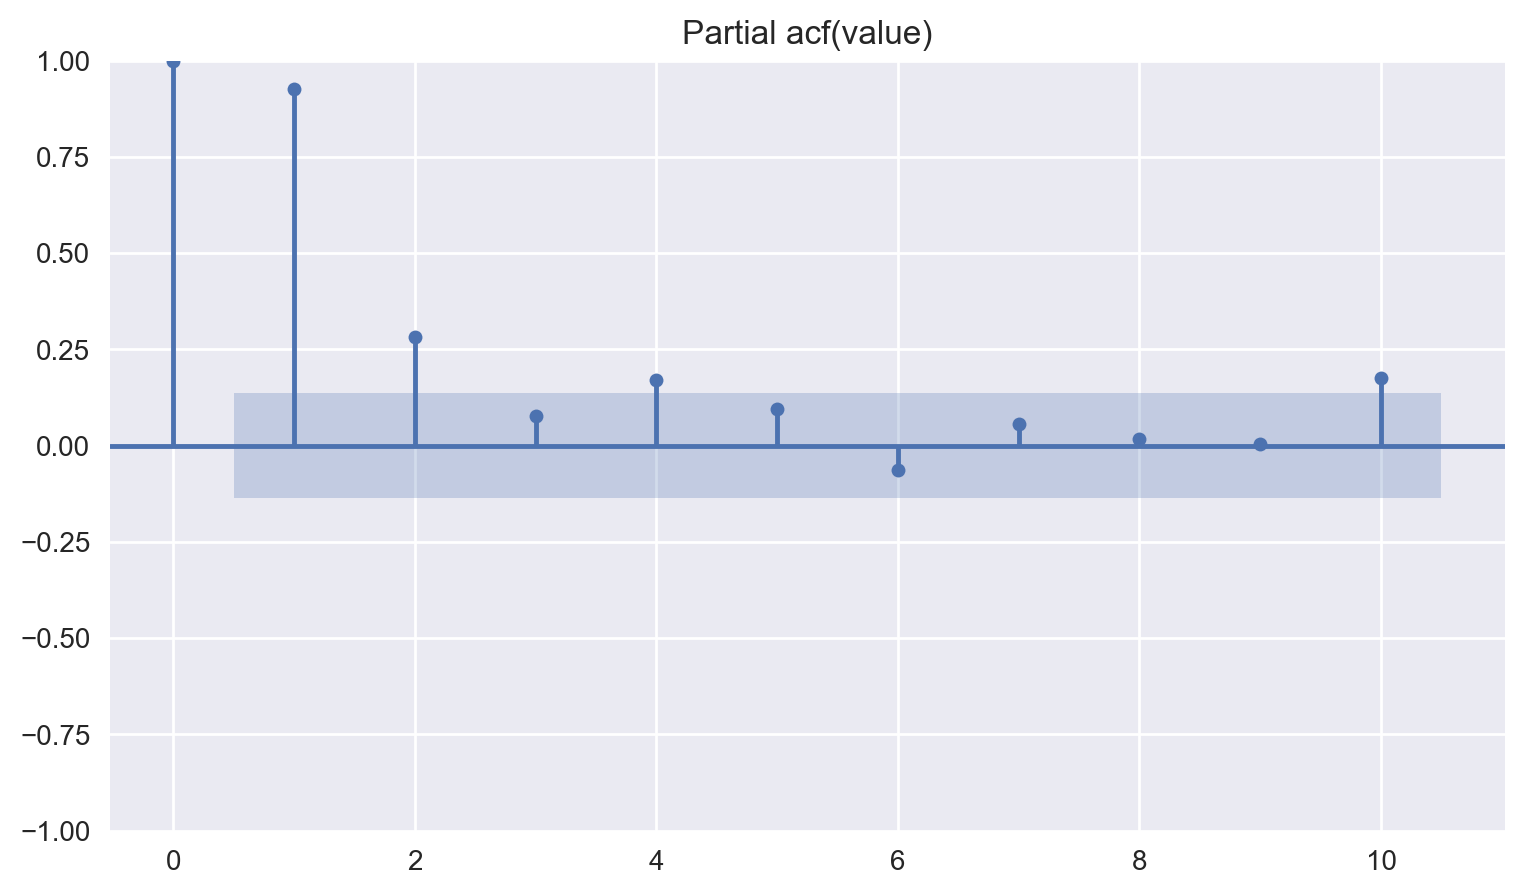

In [39]:
plot_pacf(a10_df.value, lags=10, title="Partial acf(value)")
plt.show()

Understanding the `pacf`chart:

- A large spike at lag 1 that decreases after a few lags, indicates a moving average term in the data. Then we can use the autocorrelation function to determine the `order` of the moving average term.
- A large spike at lag 1 followed by a damped wave that alternates between positive and negative correlations indicates a higher order moving average term in the data. Use the autocorrelation function to determine the order of the moving average term.
- Significant correlations at the first or second lag, followed by correlations that are not significant, indicate an autoregressive term in the data. The number of significant correlations indicate the order of the autoregressive term.

In the example above we can clearly see only the initial 2 lags as significant, which indicates an autoregressive term of order 2.

In [40]:
result_mul = seasonal_decompose(a10_df['value'], model='multiplicative', extrapolate_trend='freq')
a10_df["seasonal"] = result_mul.seasonal
a10_df["trend"] = result_mul.trend

> Important note: make sure your data **doesn’t have NA** values, otherwise the ACF will fail.
> So make sure to `a10_df.delta.iloc[0] = 0` in case the first element is `NaN`.

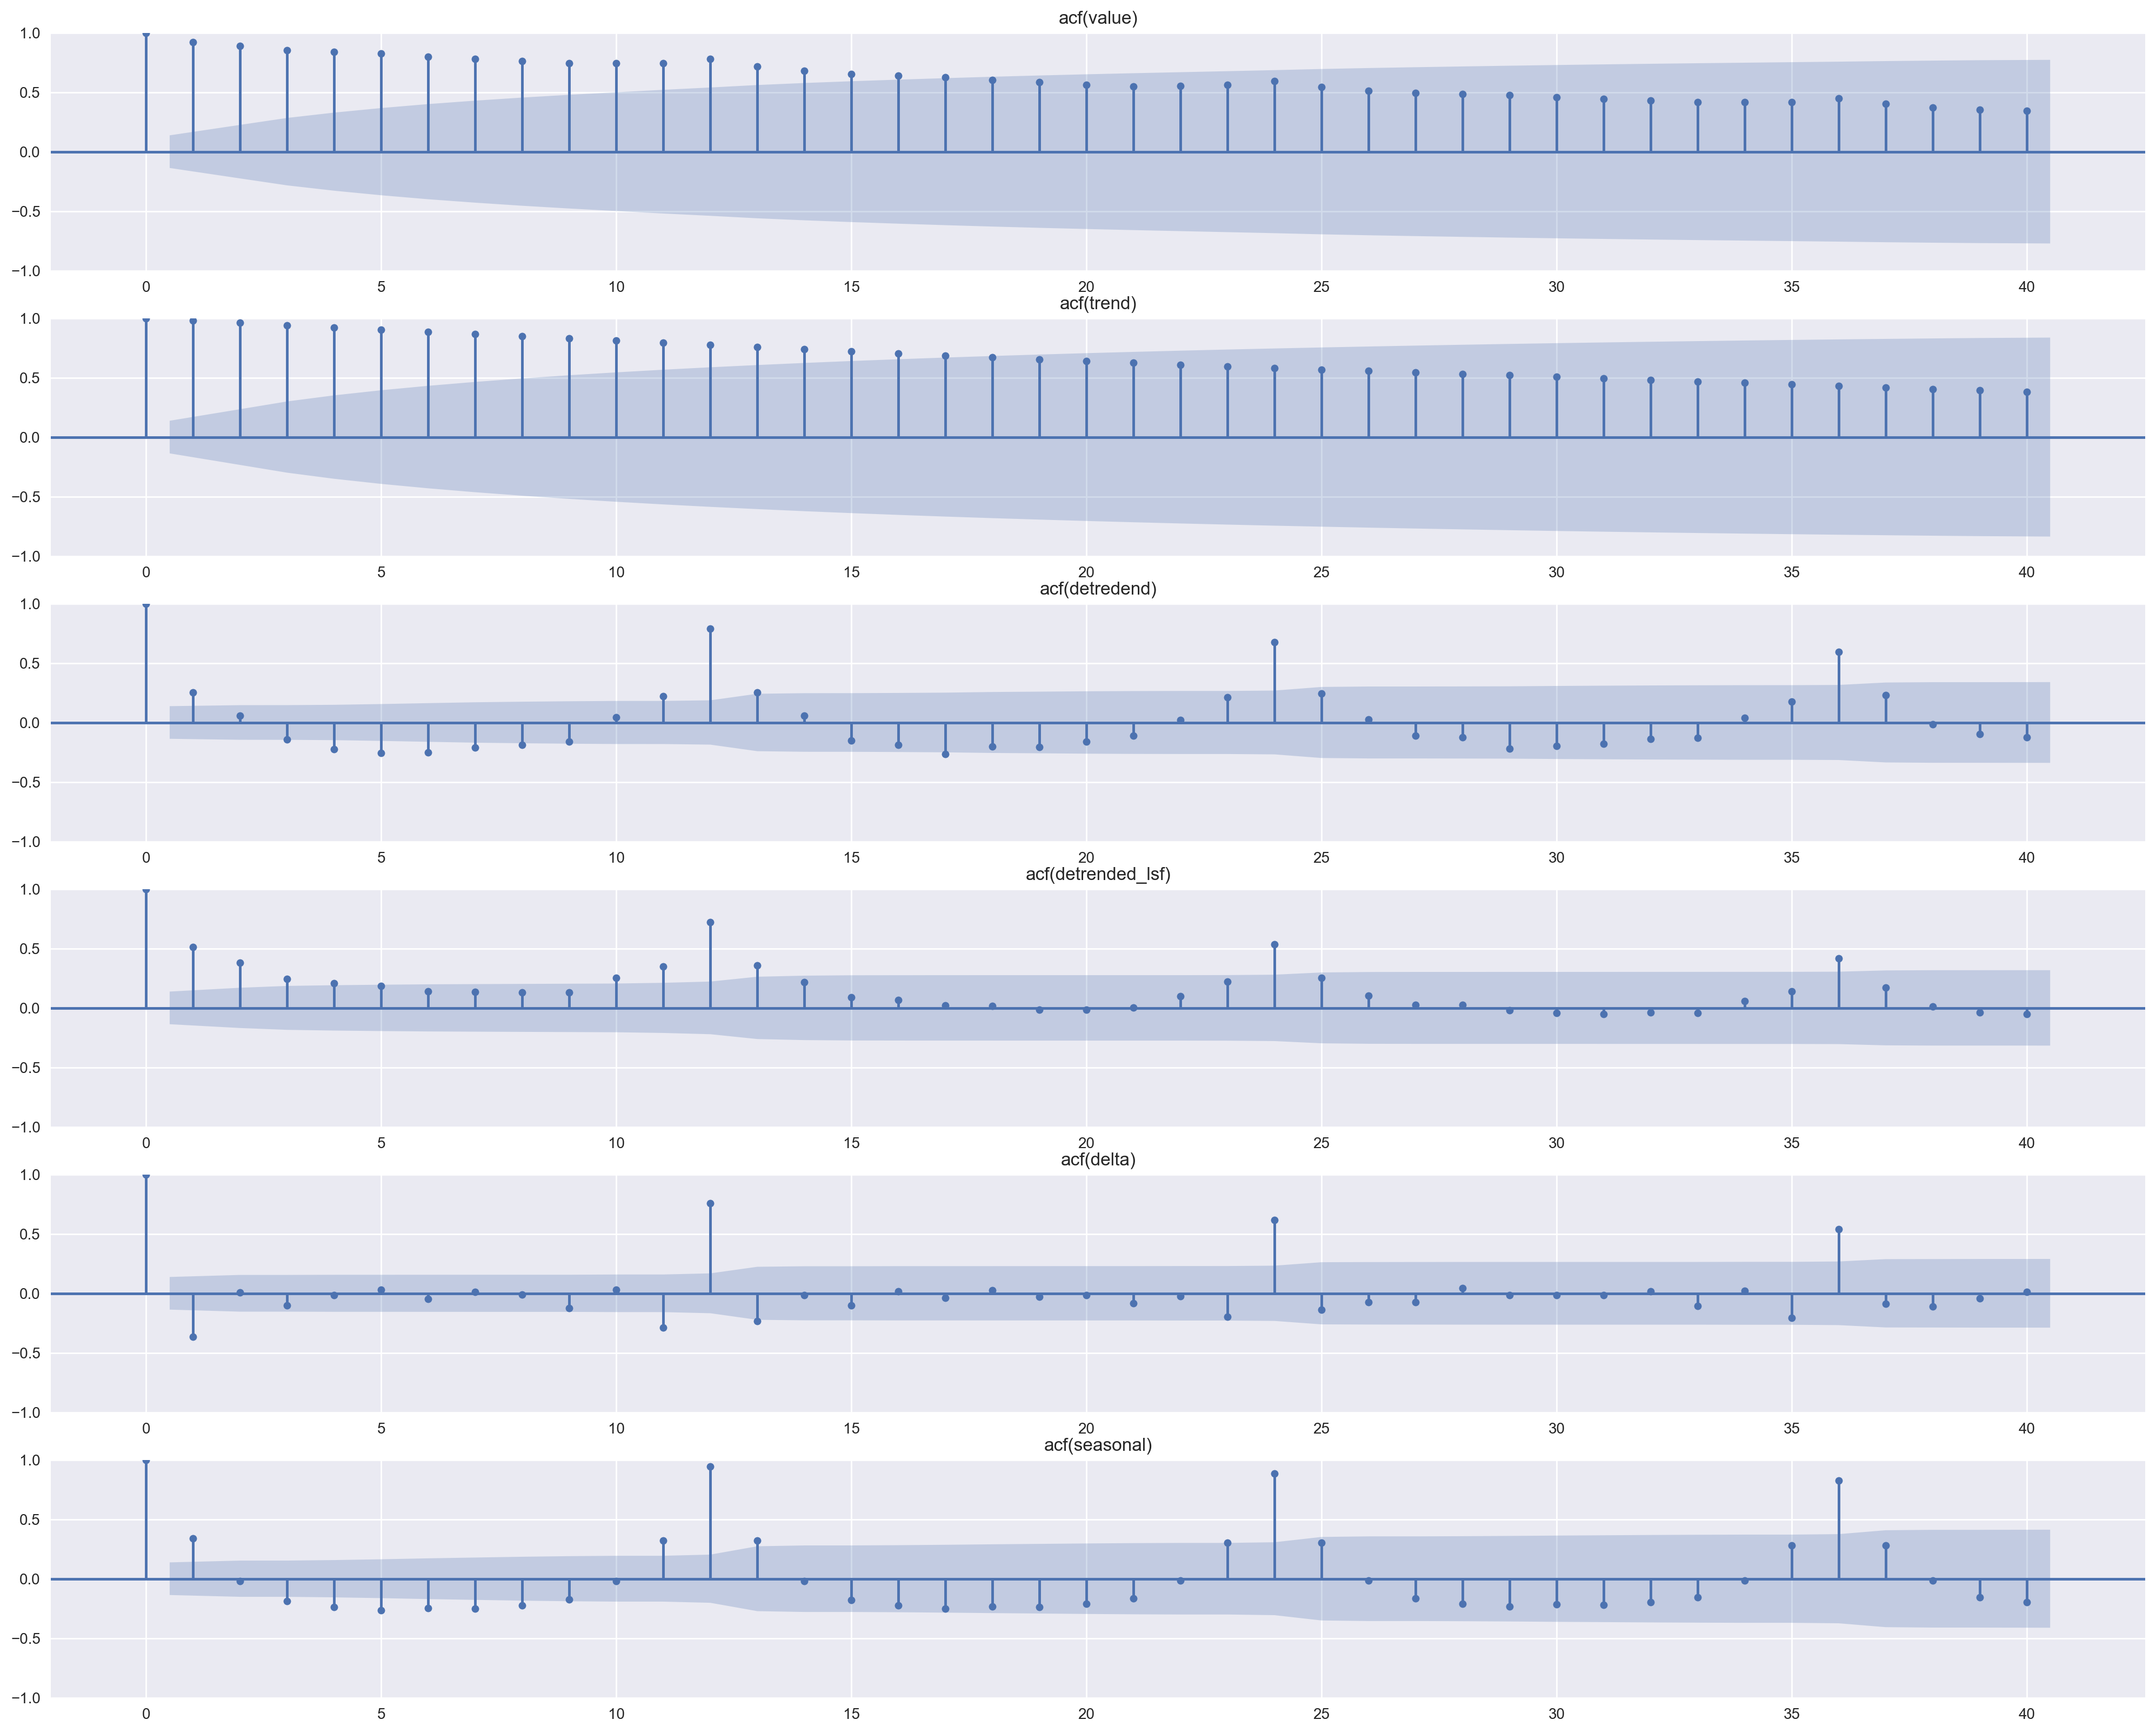

In [41]:
nlags = 40
fig, axis = plt.subplots(6, 1, figsize=(25,20))
plot_acf(a10_df.value, axis[0], lags=nlags, title="acf(value)")
plot_acf(a10_df.trend, axis[1], lags=nlags, title="acf(trend)")
plot_acf(a10_df.detrended, axis[2], lags=nlags, title="acf(detredend)")
plot_acf(a10_df.detrended_lsf, axis[3], lags=nlags, title="acf(detrended_lsf)")
plot_acf(a10_df.delta, axis[4], lags=nlags, title="acf(delta)")
plot_acf(a10_df.seasonal, axis[5], lags=nlags, title="acf(seasonal)")
plt.show()

Another alternative to check for autocorrelation is to analyse the `log plot`. Pandas provide this plot out-of-the-box.

The lag plot is a scatter plot of a time series against a lag of itself. The presence of a pattern in the plot indicates the series is autocorrelated. If there is no such pattern, the series is likely to be random white noise.

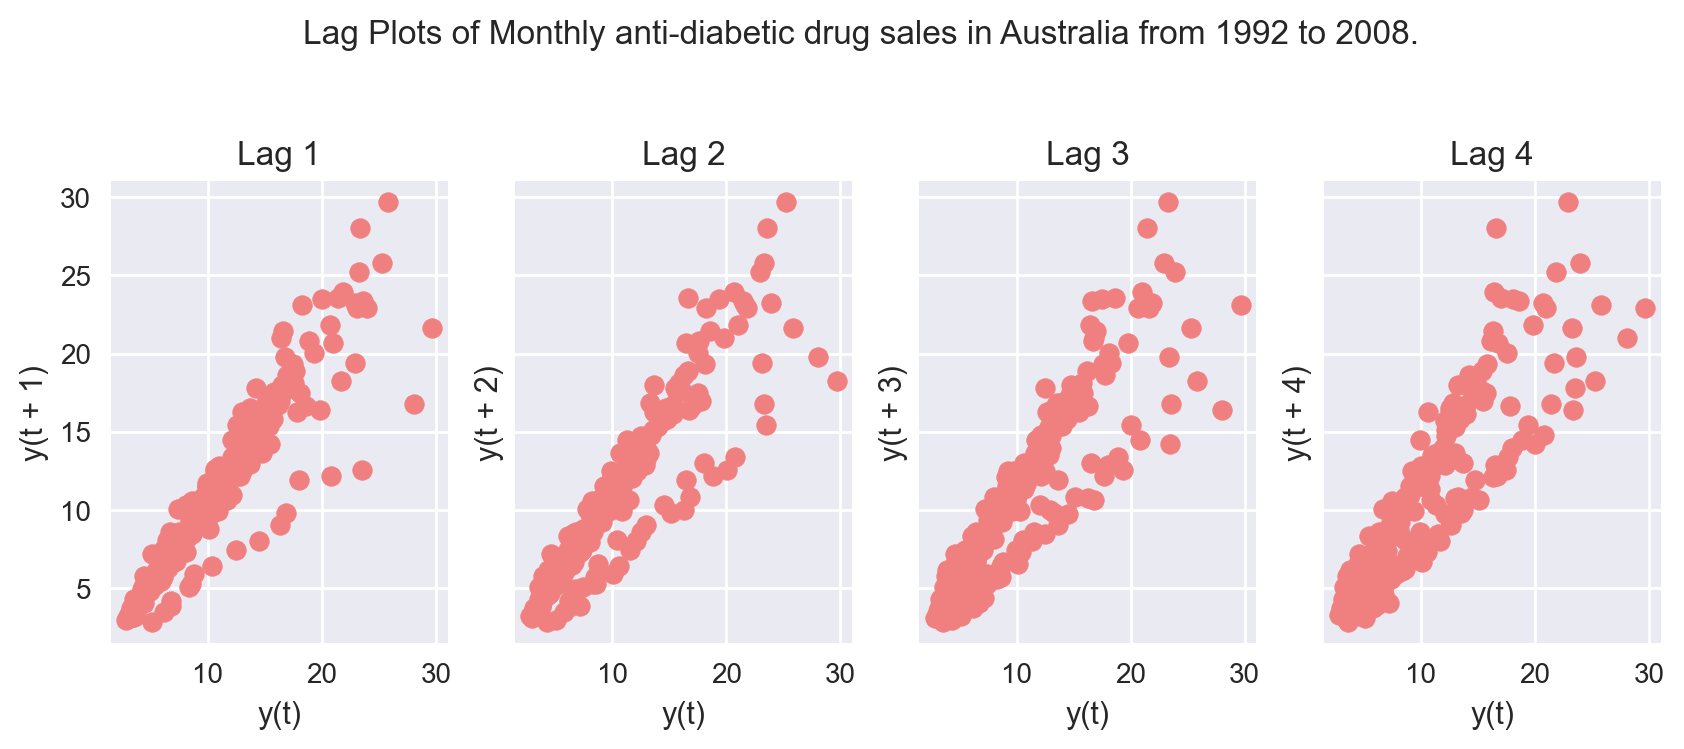

In [42]:
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(a10_df.value, lag=i + 1, ax=ax, c='lightcoral')
    ax.set_title('Lag ' + str(i + 1))
fig.suptitle('Lag Plots of Monthly anti-diabetic drug sales in Australia from 1992 to 2008.', y=1.15)    
plt.show()